In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler

In [3]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

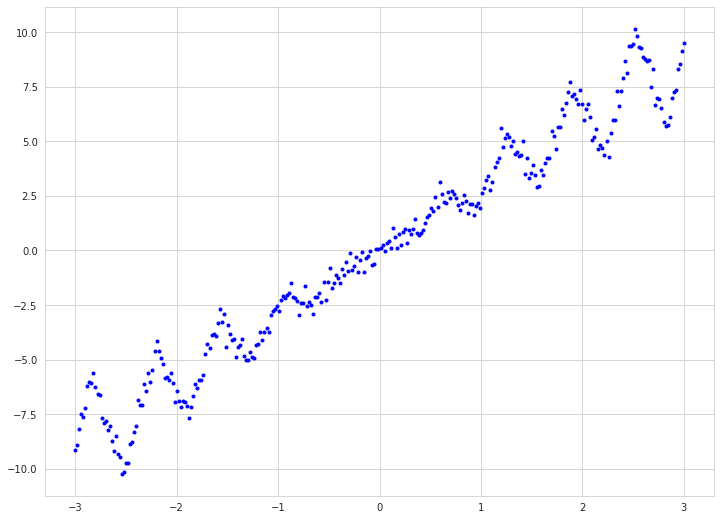

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(max_depth, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    # subplots
    fig, axs = plt.subplots(nrows=5, ncols=3, sharex=True, sharey=True)
    # x values
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    models = []
    for i, depth in enumerate(max_depth):
        # Creating a model and predicting y
        tree_reg = DecisionTreeRegressor(max_depth=depth, random_state=42).fit(X, y)
        y_pred = tree_reg.predict(x1)
        models.append(("model_" + str(depth), tree_reg))
        # Plotting
        axs.flatten()[i].axis(axes)
        axs.flatten()[i].set_xlabel("$x_1$", fontsize=18)
        if ylabel:
            axs.flatten()[i].set_ylabel(ylabel, fontsize=18, rotation=0)
        axs.flatten()[i].plot(X, y, linewidth=1, label="fit", c='#FF6961', marker='.')
        axs.flatten()[i].plot(x1, y_pred, linewidth=3, label=r"$\hat{y}$", c='#957DAD')
        axs.flatten()[i].set_title(f"Max Depth = {depth}")
        axs.flatten()[i].legend()
    
    plt.tight_layout()
    return models
    

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

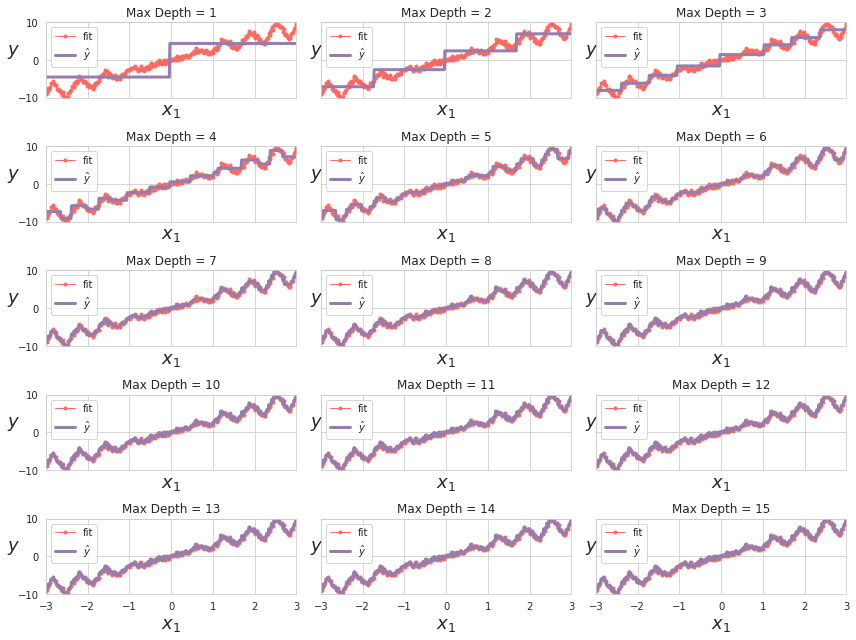

In [5]:
max_depth = list(range(1, 16))
models = plot_regression_predictions(max_depth, X, y)

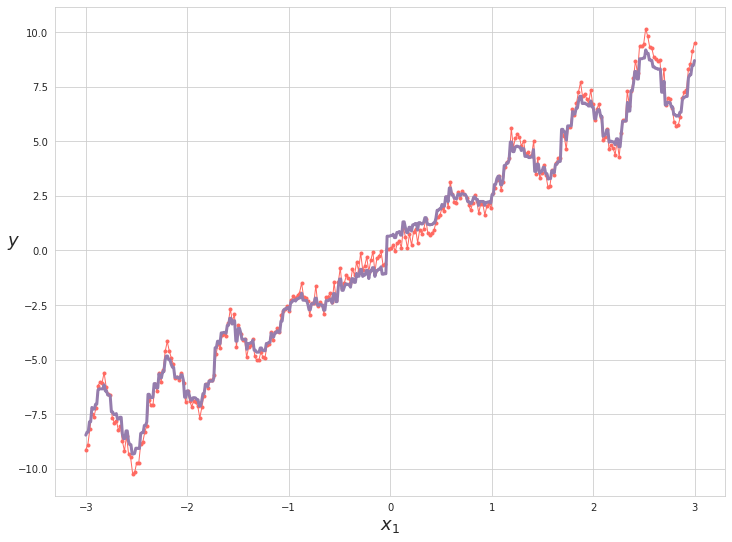

In [6]:
from sklearn.ensemble import VotingRegressor
er = VotingRegressor(models)
x1 = np.linspace(-3, 3, 500).reshape(-1, 1)
y_pred = er.fit(X, y).predict(x1)
plt.plot(X, y, linewidth=1, label="fit", c='#FF6961', marker='.')
plt.plot(x1, y_pred, linewidth=3, label=r"$\hat{y}$", c='#957DAD')
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0);

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

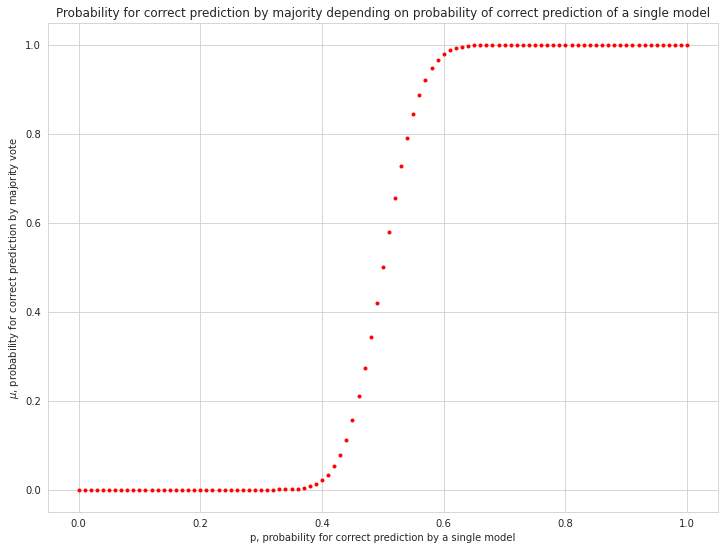

In [7]:
p_values = np.arange(0, 1.01, 0.01)
mu = [np.sum(math.comb(101, i) * p**i * (1-p)**(101-i) for i in list(range(51, 102))) for p in p_values]
plt.plot(p_values, mu, "r.")
plt.xlabel("p, probability for correct prediction by a single model")
plt.ylabel("$\mu$, probability for correct prediction by majority vote")
plt.title("Probability for correct prediction by majority depending on probability of correct prediction of a single model");

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

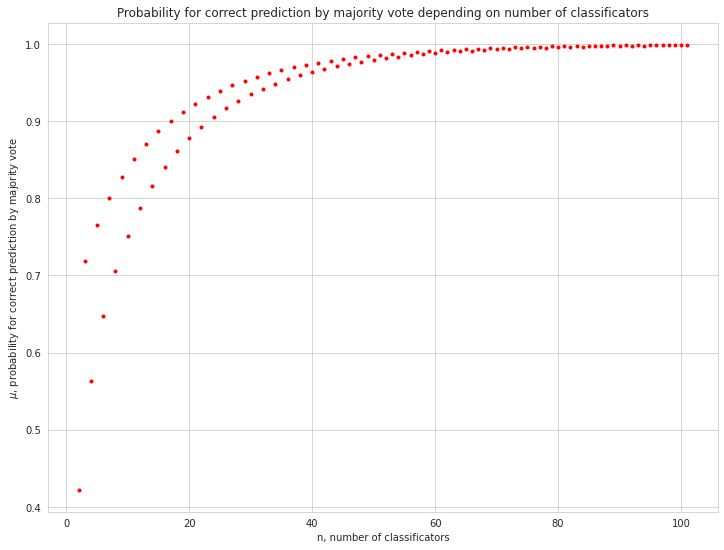

In [8]:
p = 0.65
n_class = list(range(2, 102)) 
# p_values = np.arange(0, 1.01, 0.01)
mu = [np.sum(math.comb(n, i) * p**i * (1-p)**(n-i) for i in list(range(n//2 + 1, n+1))) for n in n_class]
plt.plot(n_class, mu, "r.")
plt.xlabel("n, number of classificators")
plt.ylabel("$\mu$, probability for correct prediction by majority vote")
plt.title("Probability for correct prediction by majority vote depending on number of classificators");

Observations:

* From the first graph, we can see that already 60 \% probability prediction by a single model is enough to successfully (~100 \%) predict the whole model 
* From the second graph, around 20 classificators are enough to predict the whole model well (\~20 %) and around 60 classificators to be quite preise (\~100 \%)
* also from the second graph it is visible that odd number of classificators is better than even (obviously, because - odd number, precise answer)

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [9]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
            
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        for i in range(self.n_estimators):
            # Random state
            np.random.seed(self.random_state + i)
            
            # Selecting random n=max_features features (indices)
            self.feat_ids_by_tree.append(np.random.choice(X.shape[1], size=self.max_features, replace=False))
            
            # Creating pseudosample indices with bootstrap 
            ps_sample_ind = np.random.choice(X.shape[0], size=X.shape[0], replace=True).reshape(X.shape[0], 1)
            
            # Choosing pseudo X and y
            ps_X = X[ps_sample_ind, self.feat_ids_by_tree[i]]
            ps_y = y[ps_sample_ind]
            
            # Creating and fitting the model
            clf = DecisionTreeClassifier(max_depth=self.max_depth,
                                         max_features=self.max_features,
                                         random_state=self.random_state)
            clf.fit(ps_X, ps_y)
            
            # Appending the tree to the list with models self.trees
            self.trees.append(clf)
        
        return self

    def predict_proba(self, X):
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        probas = np.zeros(shape = (self.n_estimators, X.shape[0], len(self.classes_)))
        for i, tree in enumerate(self.trees):
                probas[i, :, :] = tree.predict_proba(X[:, self.feat_ids_by_tree[i]])
        return np.mean(probas, axis=0)
        
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)

        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [10]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

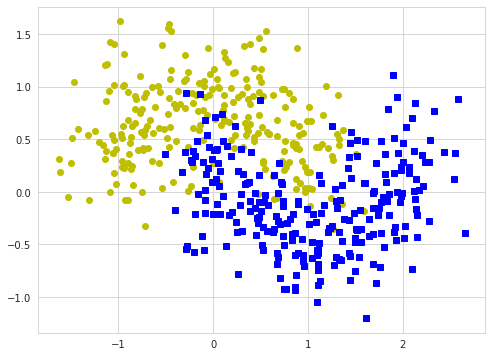

In [11]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [12]:
print(X.shape)

(500, 2)


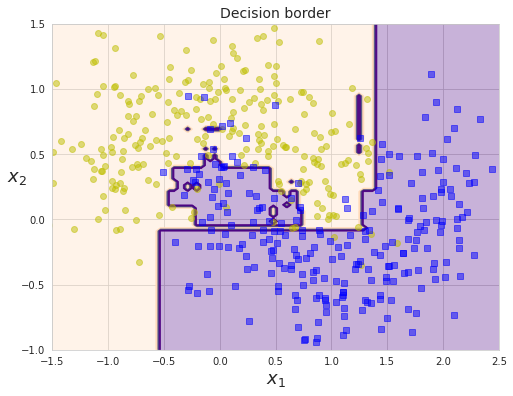

In [13]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

plt.figure(figsize=(8, 6))
clf = RandomForestClassifierCustom(max_depth=20, max_features=2, random_state=42)
clf.fit(X_train, y_train)
plot_decision_boundary(clf, X, y)
plt.title("Decision border", fontsize=14)
plt.show()

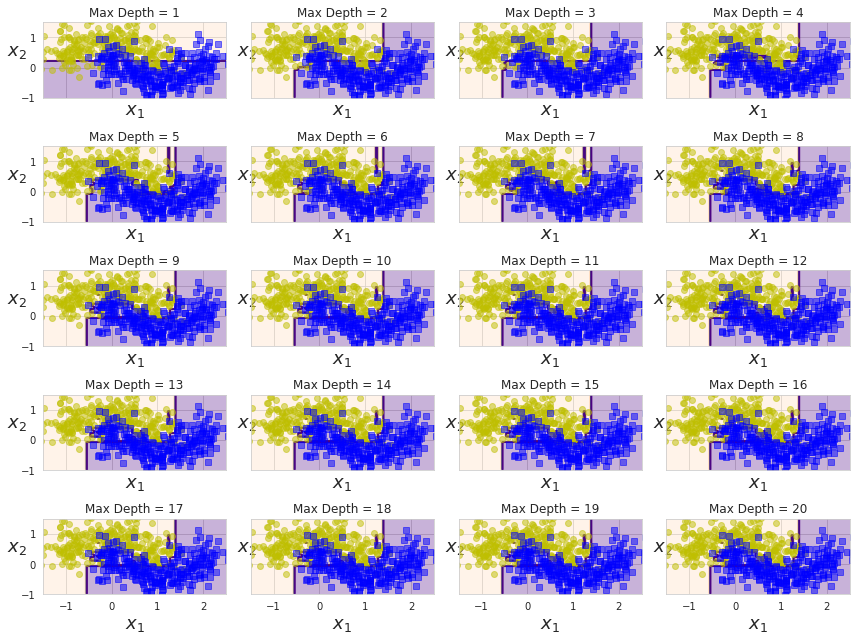

In [14]:
max_depth = list(range(1, 21))
# subplots
fig, axs = plt.subplots(nrows=5, ncols=4, sharex=True, sharey=True)
axes=[-1.5, 2.5, -1, 1.5]
alpha=0.5
contour=True
x1s = np.linspace(axes[0], axes[1], 100)
x2s = np.linspace(axes[2], axes[3], 100)
x1, x2 = np.meshgrid(x1s, x2s)
X_new = np.c_[x1.ravel(), x2.ravel()]
for i, depth in enumerate(max_depth):
    # Creating a model and predicting y
    clf = RandomForestClassifierCustom(max_depth=depth, max_features=2, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    axs.flatten()[i].contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        axs.flatten()[i].contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    axs.flatten()[i].plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    axs.flatten()[i].plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    axs.flatten()[i].axis(axes)
    axs.flatten()[i].set_xlabel(r"$x_1$", fontsize=18)
    axs.flatten()[i].set_ylabel(r"$x_2$", fontsize=18, rotation=0)
    axs.flatten()[i].set_title(f"Max Depth = {depth}")

    
plt.tight_layout()

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [15]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##


In [16]:
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

param_grid = {
    "max_depth" : list(range(1, 21)),
    "max_features": [1, 2],
    "n_estimators": list(range(10, 100, 10)) + list(range(100, 1001, 100)),
    "random_state": [42]
}


rdm_clf = GridSearchCV(estimator=RandomForestClassifierCustom(),
             param_grid=param_grid,
             scoring="f1",
             n_jobs=-1)

In [17]:
rdm_clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifierCustom(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20],
                         'max_features': [1, 2],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 200, 300, 400, 500, 600, 700,
                                          800, 900, 1000],
                         'random_state': [42]},
             scoring='f1')

In [18]:
rdm_clf.cv_results_

{'mean_fit_time': array([0.02361908, 0.03811107, 0.05268431, 0.07860045, 0.10111303,
        0.1288909 , 0.16065412, 0.21049404, 0.2498363 , 0.28711972,
        0.45678439, 0.65136404, 0.79724669, 1.06360493, 1.1968801 ,
        1.38601837, 1.57597475, 1.65999074, 1.75090756, 0.02096334,
        0.03905873, 0.05657902, 0.07357159, 0.09573131, 0.11292162,
        0.13481703, 0.14509692, 0.16984749, 0.18376813, 0.37589793,
        0.60661845, 0.83191099, 1.02314215, 1.20350876, 1.47056031,
        1.61018224, 1.78845029, 2.01106076, 0.01935334, 0.04372101,
        0.06639333, 0.09077268, 0.10770264, 0.12280979, 0.12862535,
        0.18466902, 0.18525891, 0.1847044 , 0.4127573 , 0.57948546,
        0.76890001, 1.01113224, 1.1216639 , 1.33327217, 1.55413828,
        1.74148583, 1.95696106, 0.02164583, 0.039604  , 0.0588665 ,
        0.08656869, 0.10145321, 0.11927466, 0.15457339, 0.17858176,
        0.20254602, 0.19989185, 0.44482074, 0.58899574, 0.77893825,
        0.95845809, 1.13042536,

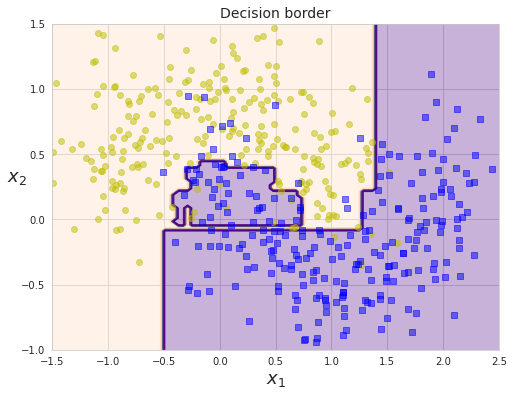

In [19]:
plt.figure(figsize=(8, 6))
clf = RandomForestClassifierCustom(n_estimators=90, max_depth=6, max_features=2, random_state=42)
clf.fit(X_train, y_train)
plot_decision_boundary(clf, X, y)
plt.title("Decision border", fontsize=14)
plt.show()

In [20]:
rdm_clf.best_params_

{'max_depth': 5, 'max_features': 2, 'n_estimators': 90, 'random_state': 42}

In [21]:
y_pred = rdm_clf.predict(X_test)

print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_pred, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_pred, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_pred, average="macro"), 4)}')

accuracy_score:	0.888
precision_score:0.8868
recall_score: 	0.8868
f1_score: 	0.8868


#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [22]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [23]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [24]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
max_features = list(range(1, X.shape[1] + 1))
dic_max_features = {}

for i in max_features:
    clf = RandomForestClassifier(max_depth=10, 
                                 max_features=i,
                                 n_estimators=200)
    clf.fit(X_train, y_train)
    
    dic_max_features[i] = base_model_pair_correlation(clf, X)

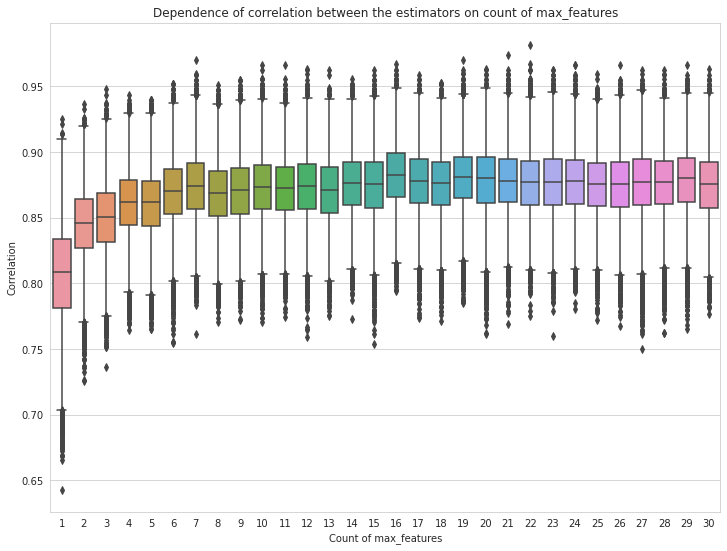

In [25]:
df = pd.DataFrame(dic_max_features)
sns.boxplot(data=df)
plt.xlabel("Count of max_features")
plt.ylabel("Correlation")
plt.title("Dependence of correlation between the estimators on count of max_features");

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [26]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
max_depth = list(range(1, 21))
dic_max_depth = {}

for i in max_depth:
    clf = RandomForestClassifier(max_depth=i, 
                                 max_features=10,
                                 n_estimators=200)
    clf.fit(X_train, y_train)
    
    dic_max_depth[i] = base_model_pair_correlation(clf, X)

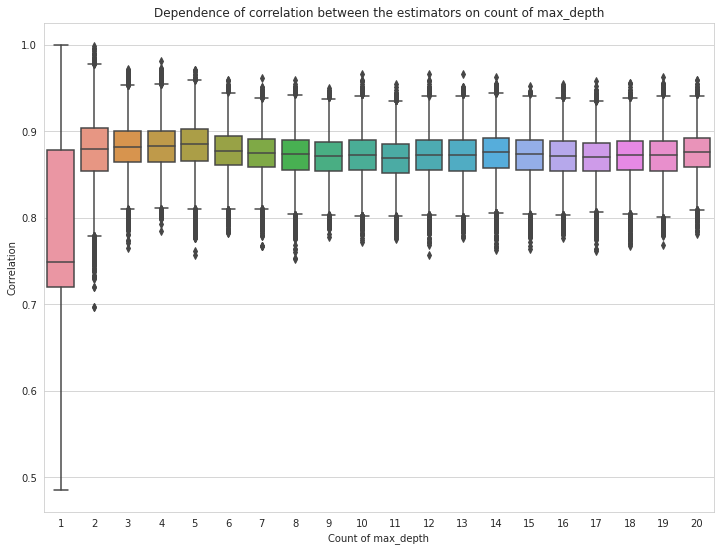

In [27]:
df_depth = pd.DataFrame(dic_max_depth)
sns.boxplot(data=df_depth)
plt.xlabel("Count of max_depth")
plt.ylabel("Correlation")
plt.title("Dependence of correlation between the estimators on count of max_depth");

Опишите ваши наблюдения:

* From max_features > 4, correlation stays approximately same - the lower the max_features count, the lower the correlation
* For max_depth < 3, there is a very high variability and range betwene 0.5 and 1 in correlation between the models, max_depth = 2 is better but still high range. For max_depth > 2 situation gets more stable

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за эксперименты и максимально высокий скор**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по [медицинским показателям](https://www.kaggle.com/ronitf/heart-disease-uci).


* 3 age: age in years
* 4 sex: sex (1 = male; 0 = female)
* 9 cp: chest pain type
    * -- Value 1: typical angina
    * -- Value 2: atypical angina
    * -- Value 3: non-anginal pain
    * -- Value 4: asymptomatic
* 10 trestbps: resting blood pressure (in mm Hg on admission to the hospital)
* 12 chol: serum cholestoral in mg/dl
* 16 fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* 19 restecg: resting electrocardiographic results
    * -- Value 0: normal
    * -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    * -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
* 32 thalach: maximum heart rate achieved
* 38 exang: exercise induced angina (1 = yes; 0 = no)
* 40 oldpeak = ST depression induced by exercise relative to rest
* 41 slope: the slope of the peak exercise ST segment
    * -- Value 1: upsloping
    * -- Value 2: flat
    * -- Value 3: downsloping
* 44 ca: number of major vessels (0-3) colored by flourosopy
* 51 thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
* 58 num: diagnosis of heart disease (angiographic disease status)
    * -- Value 0: < 50% diameter narrowing
    * -- Value 1: > 50% diameter narrowing

In [62]:
# !gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("../data/heart.csv")

In [29]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
178   43    1   0       120   177    0        0      120      1      2.5   
298   57    0   0       140   241    0        1      123      1      0.2   
201   60    1   0       125   258    0        0      141      1      2.8   
246   56    0   0       134   409    0        0      150      1      1.9   
153   66    0   2       146   278    0        0      152      0      0.0   

     slope  ca  thal  
178      1   0     3  
298      1   0     3  
201      1   1     3  
246      1   2     3  
153      1   1     2

Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [33]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED, verbosity = 0)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [31]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(estimators = base_models, voting="hard").fit(X_train, y_train)
voting_soft = VotingClassifier(estimators = base_models, voting="soft").fit(X_train, y_train)

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb]:
    model.fit(X_train, y_train)

## END YOUR CODE HERE ##
scores_dic  = {}

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {round(scores.mean(), 4)}")
    scores_dic[round(scores.mean(), 4)] = model.__class__.__name__

DecisionTreeClassifier: 0.798
RandomForestClassifier: 0.8329
CatBoostClassifier: 0.8343
ExtraTreesClassifier: 0.8282
KNeighborsClassifier: 0.6493
SVC: 0.8403
SVC: 0.6973
XGBClassifier: 0.8202
LGBMClassifier: 0.817
XGBRFClassifier: 0.8427
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
LGBMClassifier: 0.8132
LogisticRegression: 0.85
GaussianNB: 0.8141
VotingClassifier: 0.

In [32]:
dict(sorted(scores_dic.items(), reverse=True))

{0.85: 'LogisticRegression',
 0.8455: 'VotingClassifier',
 0.8427: 'XGBRFClassifier',
 0.8403: 'SVC',
 0.8396: 'VotingClassifier',
 0.8343: 'CatBoostClassifier',
 0.8329: 'RandomForestClassifier',
 0.8282: 'ExtraTreesClassifier',
 0.8202: 'XGBClassifier',
 0.817: 'LGBMClassifier',
 0.8141: 'GaussianNB',
 0.8132: 'LGBMClassifier',
 0.798: 'DecisionTreeClassifier',
 0.6973: 'SVC',
 0.6493: 'KNeighborsClassifier'}

* DecisionTreeClassifier: 0.798
* RandomForestClassifier: 0.8329
* CatBoostClassifier: 0.8343
* ExtraTreesClassifier: 0.8282
* KNeighborsClassifier: 0.6493
* SVC Linear: 0.8403
* SVC RBF: 0.6973
* XGBClassifier: 0.8202
* LGBMClassifier: 0.817
* XGBRFClassifier: 0.8427
* LGBMClassifier: 0.8132
* LogisticRegression: 0.85
* GaussianNB: 0.8141
* VotingClassifier Hard: 0.8396
* VotingClassifier Soft: 0.8455

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [30]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [34]:
corrs = np.array(base_model_pair_correlation_for_voting_clf(voting_soft, X_train))

In [35]:
ind = corrs[:, 2].argsort()[::-1]
corrs[ind]

array([[ExtraTreesClassifier(random_state=111),
        KNeighborsClassifier(weights='distance'), 1.0],
       [KNeighborsClassifier(weights='distance'),
        XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                      colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
                      gamma=0, gpu_id=-1, importance_type=None,
                      interaction_constraints='', learning_rate=0.300000012,
                      max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
                      monotone_constraints='()', n_estimators=100, n_jobs=8,
                      num_parallel_tree=1, predictor='auto', random_state=111,
                      reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
                      tree_method='exact', validate_parameters=1, verbosity=0)         ,
        0.9968823812305814],
       [ExtraTreesClassifier(random_state=111),
        XGBClassifier(base_score=0.5, booster='gbt

In [36]:
ind_095 = np.where(corrs[:, 2]>0.95) 
corrs[ind_095][:, 1:2]
for i in map(lambda x: (x[0].__class__.__name__ , x[1].__class__.__name__), corrs[ind_095]):
    print(*i)

RandomForestClassifier ExtraTreesClassifier
RandomForestClassifier KNeighborsClassifier
RandomForestClassifier CatBoostClassifier
RandomForestClassifier LGBMClassifier
RandomForestClassifier XGBClassifier
RandomForestClassifier XGBRFClassifier
ExtraTreesClassifier KNeighborsClassifier
ExtraTreesClassifier CatBoostClassifier
ExtraTreesClassifier LGBMClassifier
ExtraTreesClassifier XGBClassifier
KNeighborsClassifier CatBoostClassifier
KNeighborsClassifier LGBMClassifier
KNeighborsClassifier XGBClassifier
SVC LogisticRegression
CatBoostClassifier LGBMClassifier
CatBoostClassifier XGBClassifier
CatBoostClassifier XGBRFClassifier
LGBMClassifier XGBClassifier
LGBMClassifier XGBRFClassifier


In [37]:
dict(sorted(scores_dic.items(), reverse=True))

{0.85: 'LogisticRegression',
 0.8455: 'VotingClassifier',
 0.8427: 'XGBRFClassifier',
 0.8403: 'SVC',
 0.8396: 'VotingClassifier',
 0.8343: 'CatBoostClassifier',
 0.8329: 'RandomForestClassifier',
 0.8282: 'ExtraTreesClassifier',
 0.8202: 'XGBClassifier',
 0.817: 'LGBMClassifier',
 0.8141: 'GaussianNB',
 0.8132: 'LGBMClassifier',
 0.798: 'DecisionTreeClassifier',
 0.6973: 'SVC',
 0.6493: 'KNeighborsClassifier'}

I tried taking out all the models that correlated with each other - but the model did not get effective in any way. That's why I decided to just try out some random models.

Let's try combinations of two estimators and see which ones are the most effective:

In [34]:
def best_models_combination(model_num):
    dic_soft = {}
    dic_hard = {}
    
    base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]
    
    for i in combinations(base_models, model_num):
        voting_hard = VotingClassifier(estimators = i, voting="hard").fit(X_train, y_train)
        voting_soft = VotingClassifier(estimators = i, voting="soft").fit(X_train, y_train)
        parts = tuple(map(lambda x: str(x[1]), i))
        print(parts)
        # Hard
        scores = cross_val_score(voting_hard, X_train, y_train, cv=3, scoring="f1")
        dic_hard[parts] = scores.mean()
        print(f"{voting_hard.__class__.__name__}: {round(scores.mean(), 4)}")
        # Soft
        scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
        dic_soft[parts] = scores.mean()
        print(f"{voting_soft.__class__.__name__}: {round(scores.mean(), 4)}")
        
    
    return dic_soft, dic_hard

In [39]:
dic_soft_2, dic_hard_2 = best_models_combination(2)

('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)')
VotingClassifier: 0.7785
VotingClassifier: 0.8114
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)')
VotingClassifier: 0.7829
VotingClassifier: 0.8097
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "KNeighborsClassifier(weights='distance')")
VotingClassifier: 0.6523
VotingClassifier: 0.7541
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)")
VotingClassifier: 0.7921
VotingClassifier: 0.8251
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'SVC(probability=True, random_state=111)')
VotingClassifier: 0.7222
VotingClassifier: 0.7896
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', '<catboost.core.CatB

VotingClassifier: 0.8356
VotingClassifier: 0.831
('RandomForestClassifier(n_estimators=50, random_state=111)', "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8349
VotingClassifier: 0.8513
('RandomForestClassifier(n_estimators=50, random_state=111)', 'GaussianNB()')
VotingClassifier: 0.8262
VotingClassifier: 0.8408
('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')")
VotingClassifier: 0.6957
VotingClassifier: 0.7936
('ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)")
VotingClassifier: 0.8272
VotingClassifier: 0.855
('ExtraTreesClassifier(random_state=111)', 'SVC(probability=True, random_state=111)')
VotingClassifier: 0.7557
VotingClassifier: 0.7906
('ExtraTreesClassifier(random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>')
VotingClassifier: 0.8215
VotingClassifier: 0.8635
('ExtraTreesClassifier(random_state=111)', 'LGBMClassifier(random_state=

("SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)')
VotingClassifier: 0.7656
VotingClassifier: 0.8432
("SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>')
VotingClassifier: 0.8128
VotingClassifier: 0.8602
("SVC(kernel='linear', probability=True, random_state=111)", 'LGBMClassifier(random_state=111)')
VotingClassifier: 0.8089
VotingClassifier: 0.8392
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
("SVC(kernel='linear', probability=True, random_state=111)", "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)")
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8589
('<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_c

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8428
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
("LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "LogisticRegression(max_iter=10000, solver='liblinear')")
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Wa

In [40]:
# Best combination
print(max(dic_soft_2, key=dic_soft_2.get))

# Getting the first three most successful elements
print(sorted(dic_soft_2, key=dic_soft_2.get, reverse=True)[:3])

# Getting the value
dic_soft_2[max(dic_soft_2, key=dic_soft_2.get)] 

('<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "LogisticRegression(max_iter=10000, solver='liblinear')")
[('<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "LogisticRegression(max_iter=10000, solver='liblinear')"), ('ExtraTreesClassifier(random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>'), ("SVC(kernel='linear', probability=True, random_state=111)", "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)")]


0.8694543828264759

In [41]:
print(max(dic_hard_2, key=dic_hard_2.get))
print(sorted(dic_hard_2, key=dic_hard_2.get, reverse=True)[:3])

dic_hard_2[max(dic_hard_2, key=dic_hard_2.get)] 

("SVC(kernel='linear', probability=True, random_state=111)", "LogisticRegression(max_iter=10000, solver='liblinear')")
[("SVC(kernel='linear', probability=True, random_state=111)", "LogisticRegression(max_iter=10000, solver='liblinear')"), ('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)'), ('RandomForestClassifier(n_estimators=50, random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n 

0.8471593765711413

Let's try combinations of three estimators and see which ones are the most effective:

In [42]:
dic_soft_3, dic_hard_3 = best_models_combination(3)

('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)')
VotingClassifier: 0.8252
VotingClassifier: 0.8322
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')")
VotingClassifier: 0.8213
VotingClassifier: 0.8098
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)")
VotingClassifier: 0.8509
VotingClassifier: 0.842
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', 'SVC(probability=True, random_state=111)')
VotingClassifier: 0.8306
VotingClassifier: 0.8158
('DecisionTreeClassifier(max_depth=10, min_sampl

VotingClassifier: 0.8318
VotingClassifier: 0.814
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)")
VotingClassifier: 0.8293
VotingClassifier: 0.836
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "LogisticRegression(max_iter=100

('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)")
VotingClassifier: 0.8442
VotingClassifier: 0.8305
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "XGBRFClassifier(base_

VotingClassifier: 0.8425
VotingClassifier: 0.8253
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)")
VotingClassifier: 0.8326
VotingClassifier: 0.8533
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efb

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8523
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'GaussianNB()')
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8404
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8569
('RandomForestClassifier(n_estimators=50, random_s

('RandomForestClassifier(n_estimators=50, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)")
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8508
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8479
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8608
('RandomForestClassifier(n_estimators=50, random_s

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8526
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8294
VotingClassifier: 0.8414
('RandomForestClassifier(n_estimators=50, random_state=111)', "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8269
VotingClassifier: 0.8403
('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)")
VotingClassifier: 0.8328
VotingClassifier: 0.8343
('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)')
VotingClassifier: 0.7453
VotingClassifier: 0.7952
('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>')
VotingClassifier: 0.8287
VotingClassifier: 0.8301
('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", 'LGBMClassifier(random_state=111)')
VotingClassifier: 0.8285
VotingClassifier: 0.8221
[LightGBM] [Wa

VotingClassifier: 0.8455
VotingClassifier: 0.8615
('ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8507
VotingClassifier: 0.8505
('ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'GaussianNB()')
VotingClassifier: 0.8402
VotingClassifier: 0.8336
('ExtraTreesClassifier(random_state=111)', 'SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>')
VotingClassifier: 0.8225
VotingClassifier: 0.8201
('ExtraTreesClassifier(random_state=111)', 'SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)')
VotingClassifier: 0.8159
VotingClassifier: 0.8396
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Curr

VotingClassifier: 0.8345
VotingClassifier: 0.8291
('ExtraTreesClassifier(random_state=111)', 'LGBMClassifier(random_state=111)', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)")
VotingClassifier: 0.8288
VotingClassifier: 0.8469
('ExtraTreesClassifier(random_state=111)', 'LGBMClassifier(random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsa

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8407
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.842
VotingClassifier: 0.8452
("KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)")
VotingClassifier: 0.8447
VotingClassifier: 0.8458
("KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingC

VotingClassifier: 0.8358
VotingClassifier: 0.8374
("KNeighborsClassifier(weights='distance')", '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8447
VotingClassifier: 0.8467
("KNeighborsClassifier(weights='distance')", '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', 'GaussianNB()')
VotingClassifier: 0.8416
VotingClassifier: 0.838
("KNeighborsClassifier(weights='distance')", 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)")
VotingClassifier: 0.817
VotingClassifier: 0.797
("KNeighborsClassifier(weights='distance')", 'LGBMClassifier(random_state=111)', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constr

VotingClassifier: 0.8081
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.835
("KNeighborsClassifier(weights='distance')", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interact

VotingClassifier: 0.8625
VotingClassifier: 0.8602
("SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8523
VotingClassifier: 0.8542
("SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', 'GaussianNB()')
VotingClassifier: 0.8192
VotingClassifier: 0.8221
("SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', 'LGBMClassifier(random_state=111)')
VotingClassifier: 0.854
VotingClassifier: 0.8508
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
("SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "LGBMClass

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8447
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
("SVC(kernel='linear', probability=True, random_state=111)", "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=F

VotingClassifier: 0.8349
VotingClassifier: 0.8329
("SVC(kernel='linear', probability=True, random_state=111)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)", "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8444
VotingClassifier: 0.8533
("SVC(kernel='linear', probability=True, random_state=111)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsa

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8443
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8391
VotingClassifier: 0.8442
('SVC(probability=True, random_state=111)', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", 'GaussianNB()')
VotingClassifier: 0.8248
VotingClassifier: 0.8437
('SVC(probability=True, random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n   

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8434
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "LGBMClassi

VotingClassifier: 0.841
VotingClassifier: 0.8434
('<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.831
VotingClassifier: 0.8437
('LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validat

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8347
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8536
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8433
[LightGBM] [Warning] bagging_fraction is set=0.7, 

In [43]:
# Best combination
print(max(dic_soft_3, key=dic_soft_3.get))

# Getting the first three most successful elements
print(sorted(dic_soft_3, key=dic_soft_3.get, reverse=True)[:3])

# Getting the value
dic_soft_3[max(dic_soft_3, key=dic_soft_3.get)] 

('ExtraTreesClassifier(random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)")
[('ExtraTreesClassifier(random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)"), ('SVC(probability=True, random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n           

0.8639918648954792

In [44]:
print(max(dic_hard_3, key=dic_hard_3.get))
print(sorted(dic_hard_3, key=dic_hard_3.get, reverse=True)[:3])

dic_hard_3[max(dic_hard_3, key=dic_hard_3.get)] 

('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'LGBMClassifier(random_state=111)', "LogisticRegression(max_iter=10000, solver='liblinear')")
[('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'LGBMClassifier(random_state=111)', "LogisticRegression(max_iter=10000, solver='liblinear')"), ("LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1

0.8658193543960756

Let's try combinations of four estimators and see which ones are the most effective:

In [45]:
dic_soft_4, dic_hard_4 = best_models_combination(4)

('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')")
VotingClassifier: 0.831
VotingClassifier: 0.8295
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)")
VotingClassifier: 0.8145
VotingClassifier: 0.8516
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', 'SVC(probability=True, random_state=111)')
VotingClassifier: 0.8232
VotingClassifier: 0.8062
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesCla

('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)")
VotingClassifier: 0.8037
VotingClassifier: 0.8263
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8117
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8089
VotingClassifier: 0.8271
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', 'LGBMClassifier(random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)")
VotingClassifier: 0.8407
VotingClassifier: 0.8356
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClas

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8455
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8104
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8331
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, cols

VotingClassifier: 0.8176
VotingClassifier: 0.8299
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', 'SVC(probability=True, random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)")
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


VotingClassifier: 0.8245
VotingClassifier: 0.8567
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', 'LGBMClassifier(random_state=111)', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)")
VotingClassifier: 0.8124
VotingClassifier: 0.8302
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesCla

VotingClassifier: 0.8479
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'GaussianNB()')
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.834
[LightGBM] [Warning] bagging

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.829
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8392
('DecisionTreeClassifier(max_depth=10, min_samples_

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8169
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8236
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "KNeighborsClassifier(weights='distance')", "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n     

VotingClassifier: 0.8218
VotingClassifier: 0.8396
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "KNeighborsClassifier(weights='distance')", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)", "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8445
VotingClassifier: 0.8372
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "KNeighborsC

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8552
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.837
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be igno

VotingClassifier: 0.8384
VotingClassifier: 0.842
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)", 'GaussianNB()')
VotingClassifier: 0.8402
VotingClassifier: 0.8577
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True,

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8143
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'SVC(probability=True, random_state=111)', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8361
VotingClassifier: 0.8416
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'SVC(probability=True, random_state=111)'

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8353
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, mi

VotingClassifier: 0.8397
VotingClassifier: 0.8571
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", 'GaussianNB()')
VotingClassifier: 0.8331
VotingClassifier: 0.854
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', '<catboost.cor

VotingClassifier: 0.8223
VotingClassifier: 0.8447
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'LGBMClassifier(random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)", "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8549
VotingClassifier: 0.8524
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'LGBMClassifier(rand

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8289
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8492
[LightGBM] [Warning] bagging_fraction is set=0.7, 

VotingClassifier: 0.8413
VotingClassifier: 0.8492
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\

('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>')
VotingClassifier: 0.8396
VotingClassifier: 0.8497
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'LGBMClassifier(random_state=111)')
VotingClassifier: 0.8419
VotingClassifier: 0.8463
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n         

VotingClassifier: 0.8305
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', 'SVC(probability=True, random_state=111)', "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8345
VotingClassifier: 0.8403
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', 'SVC(probability=True, random_state=111)', 'GaussianNB()')
VotingClassifier: 0.8289
VotingClassifier: 0.8343
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', 'LGBMClassifier(random_state=111)')
VotingClassifier: 0.8371
VotingClassifier: 0.8471
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('RandomForestClassifier(n_es

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8395
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8416
[LightGBM] [Warning] bagging_fraction is set=0.7, 

VotingClassifier: 0.8524
VotingClassifier: 0.8431
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", 'GaussianNB()')
VotingClassifier: 0.843
VotingClassifier: 0.8477
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "XGBRFClassifier(base_score=0

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.7791
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8034
VotingClassifier: 0.817
('RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')", 'LGBMClassifier(random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)")
VotingClassifier: 0.8189
VotingClassifier: 0.8279
('RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')", 'LGBMClassifier(random_stat

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8424
('RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importan

VotingClassifier: 0.8393
VotingClassifier: 0.8455
('RandomForestClassifier(n_estimators=50, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)")
VotingClassifier: 0.836
VotingClassifier: 0.8483
('RandomForestClassifier(n_estimators=50, random_state=111)', "SVC(kernel='linear', probability=True, random_s

('RandomForestClassifier(n_estimators=50, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)")
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[Li

VotingClassifier: 0.8515
VotingClassifier: 0.8504
('RandomForestClassifier(n_estimators=50, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8425
VotingClassifier: 0.8561
('RandomForestClassifier(n_estimators=50, random_state=111)', "SVC(kerne

VotingClassifier: 0.8236
VotingClassifier: 0.8312
('RandomForestClassifier(n_estimators=50, random_state=111)', 'SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)")
VotingClassifier: 0.8329
VotingClassifier: 0.8372
('RandomForestClassifier(n_estimators=50, random_state=111)', 'SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8478
('RandomForestClassifier(n_estimators=50, random_state=111)', 'SVC(probability=True, random_state=111)', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importanc

('RandomForestClassifier(n_estimators=50, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)")
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


VotingClassifier: 0.8365
VotingClassifier: 0.8574
('RandomForestClassifier(n_estimators=50, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8417
VotingClassifier: 0.8494
('RandomForestClassifier(n_estimators=50, random_state=111)', '<catbo

VotingClassifier: 0.8337
VotingClassifier: 0.8481
('RandomForestClassifier(n_estimators=50, random_state=111)', 'LGBMClassifier(random_state=111)', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", 'GaussianNB()')
VotingClassifier: 0.8238
VotingClassifier: 0.841
('RandomForestClassifier(n_estimators=50, random_state=111)', 'LGBMClassifier(random_state=111)', "XGBRFClassifier(base_score=0.5, booster=

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8423
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8465
VotingClassifier: 0.8583
('RandomForestClassifier(n_estimators=50, random_state=111)', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                m

('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)")
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.7829
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=

VotingClassifier: 0.8189
VotingClassifier: 0.8202
('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", 'LGBMClassifier(random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)")
VotingClassifier: 0.8329
VotingClassifier: 0.8184
('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", 'LGBMClassifier(random_state=111)', "LogisticRegression(max_iter

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8329
('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n    

VotingClassifier: 0.8269
VotingClassifier: 0.8479
('ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)")
VotingClassifier: 0.8293
VotingClassifier: 0.8381
('ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, ra

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8362
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8445
VotingClassifier: 0.8488
('ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", 'GaussianNB()')
VotingClassifier: 0.8387
VotingClassifier: 0.8456
('ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "XGBRFClassifier(base_score=0.

VotingClassifier: 0.8231
VotingClassifier: 0.841
('ExtraTreesClassifier(random_state=111)', 'SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)', "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8351
VotingClassifier: 0.8433
('ExtraTreesClassifier(random_state=111)', 'SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)', 'GaussianNB()')
VotingClassifier: 0.8209
VotingClassifier: 0.8356
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('ExtraTreesClassifier(random_state=111)', 'SVC(probability=True, random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsamp

('ExtraTreesClassifier(random_state=111)', 'SVC(probability=True, random_state=111)', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.829
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be igno

VotingClassifier: 0.8382
VotingClassifier: 0.8575
('ExtraTreesClassifier(random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", 'GaussianNB()')
VotingClassifier: 0.8364
VotingClassifier: 0.8444
('ExtraTreesClassifier(random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "XGBRFClassifier(base_sc

VotingClassifier: 0.8404
VotingClassifier: 0.8564
('ExtraTreesClassifier(random_state=111)', 'LGBMClassifier(random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)", 'GaussianNB()')
VotingClassifier: 0.8403
VotingClassifier: 0.8314
('ExtraTreesClassifier(random_state=111)', 'LGBMClassifier(random_state=111)', "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8362
V

VotingClassifier: 0.8394
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('ExtraTreesClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n     

VotingClassifier: 0.8397
VotingClassifier: 0.8491
('ExtraTreesClassifier(random_state=111)', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8356
VotingClassifier: 0.8411
('ExtraTreesClassifier(random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                col

VotingClassifier: 0.8307
VotingClassifier: 0.8455
("KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)")
VotingClassifier: 0.8295
VotingClassifier: 0.8415
("KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", '

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
("KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "LogisticRegression(max_iter=10000, solver='liblinear')")
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8198
[LightGBM] [Warning] baggin

VotingClassifier: 0.8368
VotingClassifier: 0.8363
("KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', 'LGBMClassifier(random_state=111)')
VotingClassifier: 0.7742
VotingClassifier: 0.8184
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
("KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)")
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[L

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.84
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
("KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytre

VotingClassifier: 0.8569
("KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", 'GaussianNB()')
VotingClassifier: 0.7886
VotingClassifier: 0.8409
("KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n            

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8277
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8417
VotingClassifier: 0.8481
("KNeighborsClassifier(weights='distance')", '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)", 'GaussianNB()')
VotingClassifier: 0.8428
VotingClassifier: 0.8524
("KNeighborsClassifier(weights='distance')", '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "LogisticRegression(max_iter=10000, solver

("KNeighborsClassifier(weights='distance')", "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, int

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8329
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8495
[LightGBM] [Warning] bagging_fraction is set=0.7, 

VotingClassifier: 0.8294
VotingClassifier: 0.8479
("KNeighborsClassifier(weights='distance')", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)", "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8309
VotingClassifier: 0.8372
("SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efb

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8449
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8355
VotingClassifier: 0.8552
("SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", 'GaussianNB()')
VotingClassifier: 0.8257
VotingClassifier: 0.8326
("SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', "XGBRFClassifier(base_score=

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8382
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8299
VotingClassifier: 0.852
("SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)", 'GaussianNB()')
VotingClassifier: 0.8267
VotingClassifier: 0.8497
("SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "LogisticRe

VotingClassifier: 0.8338
VotingClassifier: 0.8243
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
("SVC(kernel='linear', probability=True, random_state=111)", "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_wei

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8374
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8386
VotingClassifier: 0.833
("SVC(kernel='linear', probability=True, random_state=111)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)", "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8267
VotingClassifier: 0.8336
('SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', 'LGBMClassifier(random_state=111)

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8415
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8175
VotingClassifier: 0.8299
('SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)")
VotingClassifier: 0.8205
VotingClassifier: 0.8492
('SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)', "LGB

VotingClassifier: 0.8301
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8443
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('SVC(probability=True, random_state=111)', "LGBMC

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8375
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8447
[LightGBM] [Warning] bagging_fraction is set=0.7, 

VotingClassifier: 0.8306
VotingClassifier: 0.8447
('<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8444
VotingClassifier: 0.8572
('<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'GaussianNB()')
VotingClassifier: 0.8329
VotingClassifier: 0.8306
('<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', 'LGBMClassifier(random_state=111)', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learn

VotingClassifier: 0.8467
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n 

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8567
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "LGBMClassi

VotingClassifier: 0.8157
VotingClassifier: 0.84
('LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8434
VotingClassifier: 0.8433
('LGBMClassifier(random_state=111)', "LGBMClassif

("LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                ma

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8239
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8435
("XGBClassifier(base_score=0.5, booster='gbtree', 

In [46]:
# Best combination
print(max(dic_soft_4, key=dic_soft_4.get))

# Getting the first three most successful elements
print(sorted(dic_soft_4, key=dic_soft_4.get, reverse=True)[:3])

# Getting the value
dic_soft_4[max(dic_soft_4, key=dic_soft_4.get)] 

('ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)")
[('ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)"), ('ExtraTreesClassifier(random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n       

0.8687728937728938

In [47]:
print(max(dic_hard_4, key=dic_hard_4.get))
print(sorted(dic_hard_4, key=dic_hard_4.get, reverse=True)[:3])

dic_hard_4[max(dic_hard_4, key=dic_hard_4.get)] 

('RandomForestClassifier(n_estimators=50, random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)", "LogisticRegression(max_iter=10000, solver='liblinear')")
[('RandomForestClassifier(n_estimators=50, random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n      

0.8573192239858907

In [36]:
dic_soft_5, dic_hard_5 = best_models_combination(5)

('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)")
VotingClassifier: 0.8319
VotingClassifier: 0.8358
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)')
VotingClassifier: 0.8275
VotingClassifier: 0.8246
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>')
VotingClassifier: 0.8256
VotingClassifier: 0.824
('De

('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)')
VotingClassifier: 0.8541
VotingClassifier: 0.8539
('DecisionTre

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.841
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be igno

VotingClassifier: 0.8401
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8316
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('DecisionTreeClassifier(max_depth=10, min_samples

VotingClassifier: 0.848
VotingClassifier: 0.8527
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', 'GaussianNB()')
VotingClassifier: 0.8405
VotingClassifier: 0.8527
('Decisi

('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", 'GaussianNB()')
VotingClassifier: 0.8394
VotingClassifier: 0.8419
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>')
VotingClassifier: 0.8272
VotingClassifier: 0.8374
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)')
VotingClassifier: 0.8306
VotingClassifier: 0.8286
[LightGBM] [Warning] bagging_fract

VotingClassifier: 0.8244
VotingClassifier: 0.8395
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n                objective='binary:logistic', predictor=None, random_state=111,\n                reg_alpha=None, scale_pos_weight=None, tree_method=None,\n                validate_parameters=None, verbosity=None)")
VotingClassifier: 0.8384
VotingClassifier: 0.8358

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8518
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.83
[LightGBM] [Warning] bagging_fraction is set=0.7, su

VotingClassifier: 0.8446
VotingClassifier: 0.8322
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')", "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n                objective='binary:logistic', predictor=None, random_state=111,\n                reg_alpha=None, scale_pos_weight=None, tree_method=None,\n                validate_parameters=None, verbosity=None)", 'GaussianNB()')
VotingClassifier: 0.8329
VotingClassifier: 0.8409
('DecisionTreeClassifier(max_depth=10, min_sam

('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)')
VotingClassifier: 0.862
VotingClassifier: 

('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n                objective='binary:logistic', predictor=None, random_state=111,\n                reg_alpha=None, scale_pos_weight=None, tree_method=None,\n                validate_parameters=None, verbosity=None)")
[LightGBM] [Warning] bagging_fractio

VotingClassifier: 0.8583
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', 'GaussianNB()')
VotingClassifier: 0.8555
VotingClassifier: 0.854
('DecisionTreeC

VotingClassifier: 0.8445
VotingClassifier: 0.8364
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', 'SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)')
VotingClassifier: 0.8488
VotingClass

VotingClassifier: 0.8504
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8381
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('DecisionTreeClassifier(max_depth=10, min_samples

VotingClassifier: 0.8516
VotingClassifier: 0.8527
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'LGBMClassifier(random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)')
VotingClassifier

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8527
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8583
[LightGBM] [Warning] bagging_fraction is set=0.7, 

VotingClassifier: 0.8491
VotingClassifier: 0.8504
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_p

VotingClassifier: 0.8459
VotingClassifier: 0.846
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tr

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8524
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8459
VotingClassifier: 0.8492
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8504
VotingClassifier

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8248
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8413
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)")
VotingClassifier: 0.8334
VotingClassifier: 0.832
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", 'LGBMClassifier(random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None

VotingClassifier: 0.8389
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8403
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('DecisionTreeClassifier(max_depth=10, min_samples

VotingClassifier: 0.8382
VotingClassifier: 0.8433
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)')
VotingClassifier: 0.8423
VotingClassifier: 0.8527
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)")
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored

VotingClassifier: 0.8504
VotingClassifier: 0.8516
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.846
VotingClassifier: 0.8631
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'GaussianNB()')
VotingClassifier: 0.8454
VotingClassifier: 0.8628
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "LogisticRegression(max_iter=10000, solver='liblinear')")
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Curre

VotingClassifier: 0.8499
VotingClassifier: 0.8621
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8467
VotingClassifier: 0.8515
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', 'SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'LGBMClassifier(random_state=111)')
VotingClassifier: 0.826
VotingClassifier: 0.8384
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(rand

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8316
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8334
VotingClassifier: 0.8354
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', 'SVC(probability=True, random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8434
VotingCl

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8348
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.849
[LightGBM] [Warning] bagging_fraction is set=0.7, s

VotingClassifier: 0.8323
VotingClassifier: 0.8492
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassif

VotingClassifier: 0.8404
VotingClassifier: 0.8415
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', 'LGBMClassifier(random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8564
VotingClassifie

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8567
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8571
[LightGBM] [Warning] bagging_fraction is set=0.7, 

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8469
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8288
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_s

VotingClassifier: 0.8478
VotingClassifier: 0.8443
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", 'LGBMClassifier(random_state=111)', "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n                objective='binary:logistic', predictor=None, random_state=111,\n                reg_alpha=None, scale_pos_weight=None, tree_method=None,\n                validate_parameters=None, verbosity=None)")
VotingClassifier: 0.8576
VotingClassifier: 0.8327
('DecisionTreeClassifier(ma

('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'GaussianNB()')
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.855
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: baggin

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8294
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8271
('DecisionTreeClassifier(max_depth=10, min_samples

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8348
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n               

VotingClassifier: 0.8403
VotingClassifier: 0.8457
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', 'GaussianNB()')
VotingClassifier: 0.8303
VotingClassifier: 0.8489
('DecisionTreeClassifie

VotingClassifier: 0.844
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "KNeighborsClassifier(weights='distance')", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n               

VotingClassifier: 0.8422
VotingClassifier: 0.8488
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "KNeighborsClassifier(weights='distance')", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', 'GaussianNB()')
VotingClassifier: 0.8289
VotingClassifier: 0.8441
('D

VotingClassifier: 0.8478
VotingClassifier: 0.8395
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "KNeighborsClassifier(weights='distance')", 'LGBMClassifier(random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', 'GaussianNB()')
VotingClassifier: 0.8443
VotingClassifier: 0.8411
('DecisionTreeClassifier(max_d

VotingClassifier: 0.8488
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "KNeighborsClassifier(weights='distance')", "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, r

('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "KNeighborsClassifier(weights='distance')", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, im

VotingClassifier: 0.8514
VotingClassifier: 0.8464
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8599
VotingClassifier: 0.8433
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'GaussianNB()')
VotingClassifier: 0.8423
VotingClassifier: 0.851
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_typ

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "LogisticRegression(max_iter=10000, solver='liblinear')")
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Curr

VotingClassifier: 0.8531
VotingClassifier: 0.8428
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8446
VotingClassifier: 0.8387
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)")
VotingClassifier: 0.853
VotingClassifier: 0.8583
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'LGBMClassifier(random_state=111)', 'XGBCl

('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "LogisticRegression(max_iter=10000, solver='liblinear')")
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.852
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is s

VotingClassifier: 0.8504
VotingClassifier: 0.8621
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8395
VotingClassifier: 0.8604
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n

VotingClassifier: 0.8583
VotingClassifier: 0.8584
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'LGBMClassifier(random_state=111)', "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8478
VotingClassifier: 0.8522
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gam

('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n                objective='binary:logistic', predictor=None, random_state=111,\n                reg_alpha=None, scale_pos_weight=None, tree_method=None,\n                validate_parameters=None, verbosity=None)", "LogisticRegression(max_iter=10000, solver='liblinear')")
[LightGBM] [Warning] bagging_fraction i

VotingClassifier: 0.8552
VotingClassifier: 0.8549
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8478
VotingClassifier:

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.844
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be igno

VotingClassifier: 0.8498
VotingClassifier: 0.8332
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n                objective='binary:logistic', predictor=None, random_state=111,\n                reg_alpha=None, scale_pos_weight=None, tree_method=None,\n                validate_parameters=None, verbosity=None)", 'GaussianNB()')
VotingClassifier: 0.8413
VotingClassifier: 0.8457
('DecisionTreeClassifier(max_depth=10, min_sa

VotingClassifier: 0.8629
VotingClassifier: 0.8535
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)', "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n                objective='binary:logistic', predictor=None, random_state=111,\n                reg_alpha=None, scale_pos_weight=None, tree_method=None,\n                validate_parameters=None, verbosity=None)", 'GaussianNB()')
VotingClassifier: 0.8515
VotingClassifier: 0.854
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=

VotingClassifier: 0.8444
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.854
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('DecisionTreeClassifier(max_depth=10, min_samples_

VotingClassifier: 0.8591
VotingClassifier: 0.8581
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'SVC(probability=True, random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=Fa

VotingClassifier: 0.856
VotingClassifier: 0.8531
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'LGBMClassifier(random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', 'GaussianNB()')
VotingClassifier: 0.8523
VotingClassifier: 0.854
('DecisionTre

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8571
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n       

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8628
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_cate

VotingClassifier: 0.8563
VotingClassifier: 0.8531
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', 'GaussianNB()')
VotingClassifi

VotingClassifier: 0.8571
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=

VotingClassifier: 0.8576
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n                objective='binary:logistic', predictor=None, random_state=111,\n                reg_alpha=None, scale_pos

VotingClassifier: 0.8378
VotingClassifier: 0.8415
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8411
VotingClassifier: 0.8506
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", 'GaussianNB()')
VotingClassifier: 0.8456
VotingClassifier: 0.8345
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>')
VotingClassifier: 0.826
VotingClassifier: 0.8277
('RandomForestClassifier(n_estimators=50, random_state=11

VotingClassifier: 0.8345
VotingClassifier: 0.8349
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n                objective='binary:logistic', predictor=None, random_state=111,\n                reg_alpha=None, scale_pos_weight=None, tree_method=None,\n                validate_parameters=None, verbosity=None)")
VotingClassifier: 0.836
VotingClassifier: 0.8346
('RandomForestClassifier(n_estimators

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8394
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesCl

VotingClassifier: 0.8446
VotingClassifier: 0.8449
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n                objective='binary:logistic', predictor=None, random_state=111,\n                reg_alpha=None, scale_pos_weight=None, tree_method=None,\n                validate_parameters=None, verbosity=None)", 'GaussianNB()')
VotingClassifier: 0.8396
VotingClassifier: 0.8524
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier

VotingClassifier: 0.841
VotingClassifier: 0.8515
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n                objective='binary:logistic', predictor=None, random_state=111,\n                reg_alpha=None, scale_pos_weight=None, tree_method=None,\n                validate_parameters=None, verbosity=None)")
VotingClassifier: 0.8423
VotingClassifier: 0.8455
('RandomForestClassif

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8479
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesCl

VotingClassifier: 0.8374
VotingClassifier: 0.8506
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n                objective='binary:logistic', predictor=None, random_state=111,\n                reg_alpha=None, scale_pos_weight=None, tree_method=None,\n                validate_parameters=None, verbosity=None)", 'GaussianNB()')
VotingClassifier: 0.8329
VotingClassifier: 0.8452
('RandomForestClassifier(n_estimators=50, random_state=111)', 'Extr

VotingClassifier: 0.829
VotingClassifier: 0.8381
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', 'SVC(probability=True, random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_paral

VotingClassifier: 0.8323
VotingClassifier: 0.844
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', 'SVC(probability=True, random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8436
VotingClassifier: 0.8483
('

VotingClassifier: 0.843
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.843
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('RandomForestClassifier(n_estimators=50, random_sta

VotingClassifier: 0.8457
VotingClassifier: 0.8471
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', 'GaussianNB()')
VotingClassifier: 0.836
VotingClassifier: 0.8527
('RandomForestClassifier

VotingClassifier: 0.8428
VotingClassifier: 0.8398
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', 'LGBMClassifier(random_state=111)', "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n                objective='binary:logistic', predictor=None, random_state=111,\n                reg_alpha=None, scale_pos_weight=None, tree_method=None,\n                validate_parameters=None, verbosity=None)", "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8443
VotingClassifier: 0.8527
('RandomForestClassifier(n_estimators=50, random_

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8482
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8443
VotingClassifier: 0.8482
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n 

VotingClassifier: 0.8396
VotingClassifier: 0.8466
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)")
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, 

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8492
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8491
VotingClassifier: 0.8502
('RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8564
VotingC

VotingClassifier: 0.8296
VotingClassifier: 0.8371
('RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'GaussianNB()')
VotingClassifier: 0.8278
VotingClassifier: 0.8475
('RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)")
VotingClassifier: 0.8152
VotingClassifier: 0.8269
('RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n          

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8336
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8404
VotingClassifier: 0.8344
('RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)")
VotingClassifier: 0.8302
VotingClassifier: 0.8151
('RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'LGBMClassifier(random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missin

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8564
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8495
[LightGBM] [Warning] bagging_fraction is set=0.7, 

VotingClassifier: 0.8476
('RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')", 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)')
VotingClassifier: 0.8337
Voti

('RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')", "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                c

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8479
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8488
('RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8537
VotingClassifier: 0.8569
('RandomForestClassifier(n_estimators=50, random_st

VotingClassifier: 0.8424
VotingClassifier: 0.8467
('RandomForestClassifier(n_estimators=50, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)', "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8451
VotingClassifier: 0.8502
('RandomForestClassifier(n_estimators=50, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)', 'GaussianNB()')
VotingClassifier: 0.8353
VotingClassifier: 0.8379
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('RandomForestClassifier(n_estimators=50, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, rand

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8329
('RandomForestClassifier(n_estimators=50, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child

VotingClassifier: 0.8455
VotingClassifier: 0.8539
('RandomForestClassifier(n_estimators=50, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'LGBMClassifier(random_state=111)', "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8587
VotingClassifier: 0.8634
('RandomForestClassifier(n_estimators=50, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'LGBMClassifier(random_state=111)', 'GaussianNB()')
VotingClassifier: 0.8396
VotingClassifier: 0.8407
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('RandomForestClassifier(n_estimators=50, random_state=111)', "SVC(kernel='linear', probability=True, random_

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8538
('RandomForestClassifier(n_estimators=50, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n   

VotingClassifier: 0.8587
VotingClassifier: 0.8602
('RandomForestClassifier(n_estimators=50, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'GaussianNB()')
VotingClassifier: 0.8428
VotingClassifier: 0.8377
('RandomForestClassifier(n_estimators=50, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'LGBMClassifier(random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8539
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('RandomForestClassifier(n_estimators=50, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8508
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

('RandomForestClassifier(n_estimators=50, random_state=111)', 'SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'LGBMClassifier(random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)')
VotingClassifier: 0.8396
VotingClassifier: 0.8362
('RandomForestClassifier(n_estimators=50, random_sta

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8454
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('RandomForestClassifier(n_estimators=50, random_state=111)', 'SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'GaussianNB()')
[Light

VotingClassifier: 0.8479
VotingClassifier: 0.8395
('RandomForestClassifier(n_estimators=50, random_state=111)', 'SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n                objective='binary:logistic', predictor=None, random_state=111,\n                reg_alpha=None, scale_pos_weight=None, tree_method=None,\n                validate_parameters=None, verbosity=None)")
VotingClassifier: 0.8443
VotingClassifier: 0.8

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8443
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

('RandomForestClassifier(n_estimators=50, random_state=111)', 'SVC(probability=True, random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n                objective='binary:logistic', predictor=None, random_state=111,\n                reg_alpha=None, scale_pos_weight=None, tree_method=None,\n                validate_parameters=None, verbosity=None)", 'GaussianNB()')
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7

VotingClassifier: 0.8296
VotingClassifier: 0.8395
('RandomForestClassifier(n_estimators=50, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, 

VotingClassifier: 0.8408
VotingClassifier: 0.8391
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('RandomForestClassifier(n_estimators=50, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n     

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8491
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.836
VotingClassifier: 0.8523
('RandomForestClassifier(n_estimators=50, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8408
VotingClassifier: 0.8491
('Random

VotingClassifier: 0.8574
VotingClassifier: 0.8481
('RandomForestClassifier(n_estimators=50, random_state=111)', 'LGBMClassifier(random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n       

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.841
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8491
[LightGBM] [Warning] bagging_fraction is set=0.7, s

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8293
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8394
VotingClassifier: 0.8328
('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", 'LGBMClassifier(random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)')
VotingClassifier: 0.8478
VotingClassifier: 0.8491
('ExtraTreesClassifier(

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8538
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'GaussianNB()')
[LightGBM] [Warning] baggin

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8306
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8397
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None,

VotingClassifier: 0.8344
VotingClassifier: 0.8474
('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', 'GaussianNB()')
VotingClassifier: 0.8261
VotingClassifier: 0.8409
('ExtraTreesClassifier(random_state=111)', "KNeighborsClassi

('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n                objective='binary:logistic', predictor=None, random_state=111,\n                reg_alpha=None, scale_pos_weight=None, tree_method=None,\n                validate_parameters=None, verbosity=None)")
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Curren

VotingClassifier: 0.8458
VotingClassifier: 0.841
('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n                objective='binary:logistic', predictor=None, random_state=111,\n                reg_alpha=None, scale_pos_weight=None, tree_method=None,\n                validate_parameters=None, verbosity=None)", "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8524
VotingClassifier: 0.8472
('ExtraTreesClassifier(random_state=111)

VotingClassifier: 0.8465
VotingClassifier: 0.8436
('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", 'LGBMClassifier(random_state=111)', "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n                objective='binary:logistic', predictor=None, random_state=111,\n                reg_alpha=None, scale_pos_weight=None, tree_method=None,\n                validate_parameters=None, verbosity=None)", 'GaussianNB()')
VotingClassifier: 0.8382
VotingClassifier: 0.8452
('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", 'LGBMClassifier(rando

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8378
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytr

VotingClassifier: 0.846
VotingClassifier: 0.8514
('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu

VotingClassifier: 0.8501
VotingClassifier: 0.8495
('ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)', "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n                objective='binary:logistic', predictor=None, random_state=111,\n                reg_alpha=None, scale_pos_weight=None, tree_method=None,\n                validate_parameters=None, verbosity=None)")
VotingClassifier: 0.8459
VotingClassifier: 0.8555
('ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', 

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8386
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8455
VotingClassifier: 0.8527
('ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'LGBMClassifier(random_state=111)', "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8538
VotingClassifier: 0.8544
('ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'LGBMClassifier(random_state=111)', 'GaussianNB()')
VotingClassifier: 0.8314
VotingClassifier: 0.8411
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8532
('ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_chil

VotingClassifier: 0.8532
VotingClassifier: 0.8496
('ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'GaussianNB()')
VotingClassifier: 0.8473
VotingClassifier: 0.8377
('ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'LGBMClassifier(random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n           

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8528
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              co

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8528
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8358
VotingClassifier: 0.8514
('ExtraTreesClassifier(random_state=111)', 'SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'LGBMClassifier(random_state=111)', "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n                objective='binary:logistic', predictor=None, random_state=111,\n                reg_alpha=None, scale_pos_weight=None, tree_method=None,\n                validate_parameters=None, verbosity=None)")
VotingClassifier: 0.8393
VotingClassifier: 0.8464
('ExtraTreesClassifier(random_state=111)', 'SVC(probability=Tr

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8359
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8369
VotingClassifier: 0.8398
('ExtraTreesClassifier(random_state=111)', 'SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8484
VotingClassifier: 0.8483
('ExtraTreesClassifier(random_state=111)', 'SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'GaussianNB()')
VotingClassifier: 0.827
VotingClassifier: 0.8308
('ExtraTreesClassifier(random_state=111)', 'SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=

VotingClassifier: 0.8415
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8418
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('ExtraTreesClassifier(random_state=111)', 'SVC(pr

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.845
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be igno

VotingClassifier: 0.8384
VotingClassifier: 0.8371
('ExtraTreesClassifier(random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n                objective='binary:logistic', predictor=None, random_state=111,\n                reg_alpha=None, scale_pos_weight=None, tree_method=None,\n                validate_parameters=None, verbosity=None)")
VotingClassifier: 0.8362
VotingClassifier: 0.

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8407
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('ExtraTreesClassifier(random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n                objective='binary:logistic', predictor=None, random_state=111,\n                reg_alpha=None, scale_po

VotingClassifier: 0.8431
VotingClassifier: 0.8459
('ExtraTreesClassifier(random_state=111)', 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=N

VotingClassifier: 0.841
VotingClassifier: 0.8352
('ExtraTreesClassifier(random_state=111)', 'LGBMClassifier(random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8511
VotingClassifier: 0.8361
('ExtraTreesClassifier(random_state=111)', 'LGBMClassi

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8469
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8464
VotingClassifier: 0.859
("KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8601
VotingClassifier: 0.8435
("KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'GaussianNB()')
VotingClassifier: 0.8326
VotingClassifier: 0.8324
("KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)")
VotingClassifier: 0.8267
VotingClassifier: 0.848
("KNeighbors

("KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "LogisticRegression(max_iter=10000, solver='liblinear')")
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8571
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value:

VotingClassifier: 0.8305
VotingClassifier: 0.8324
("KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8329
VotingClassifier: 0.834
("KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)")
VotingClassifier: 0.8436
VotingClassifier: 0.8464
("KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'LGBMClassifier(random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, col

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8543
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8408
VotingClassifier: 0.8446
("KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)')
Votin

("KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                co

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8514
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8524
("KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8413
VotingClassifier: 0.8411
("KNeighborsClassifier(weights='distance')", "SVC(ke

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8412
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8317
[LightGBM] [Warning] bagging_fraction is set=0.7, 

VotingClassifier: 0.8422
VotingClassifier: 0.8427
("KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n                objective='binary:logistic', predictor=None, random_state=111,\n                reg_alpha=None, scale_pos_weight=None, tree_method=None,\n                validate_parameters=None, verbosity=None)", 'GaussianNB()')
VotingClassifier: 0.829
VotingClassifier: 0.855
("KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=1

VotingClassifier: 0.8288
VotingClassifier: 0.8578
("KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)', "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8373
VotingClassifier: 0.8427
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
("KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8381
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8451
[LightGBM] [Warning] bagging_fraction is set=0.7, 

VotingClassifier: 0.8408
VotingClassifier: 0.8395
("KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n                objective='binary:logistic', predictor=None, random_state=111,\n                reg_alpha=None, scale_pos_weight=None, tree_method=None,\n                validate_parameters=None, verbosity=None)", "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8413
VotingClassifier: 0.8355
("KNeighborsClassifier(weights='distance')", '<catboost.core.CatBoostClassifier objec

VotingClassifier: 0.8325
VotingClassifier: 0.8498
("KNeighborsClassifier(weights='distance')", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'LGBMClassifier(random_state=111)', "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8411
VotingClassifier: 0.8452
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
("KNeighborsClassifier(weights='distance')", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, inter

("KNeighborsClassifier(weights='distance')", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n                objective='binary:logistic', predictor=None, random_state=111,\n                reg_alpha=None, scale_pos_weight=None, tree_method=None,\n                validate_parameters=None, verbosity=None)", "LogisticRegression(max_iter=10000, solver='liblinear')")
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be

VotingClassifier: 0.8405
VotingClassifier: 0.8477
("KNeighborsClassifier(weights='distance')", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8493
VotingClassifier: 0.8524
("KNeighborsClassifier(w

VotingClassifier: 0.8527
VotingClassifier: 0.8455
("KNeighborsClassifier(weights='distance')", 'LGBMClassifier(random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=N

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.843
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8426
[LightGBM] [Warning] bagging_fraction is set=0.7, s

VotingClassifier: 0.842
VotingClassifier: 0.8459
("SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'LGBMClassifier(random_state=111)', "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n                objective='binary:logistic', predictor=None, random_state=111,\n                reg_alpha=None, scale_pos_weight=None, tree_method=None,\n                validate_parameters=None, verbosity=None)")
VotingClassifier: 0.8504
VotingClassifier: 0.8504
("SVC(kernel='linear', probability=True, rand

("SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'GaussianNB()')
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8378
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightG

VotingClassifier: 0.8503
VotingClassifier: 0.8504
("SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8604
VotingClassifier: 0.8587
("SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'GaussianNB()')
VotingClassifier: 0.8395
VotingClassifier: 0.8255
("SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n    

VotingClassifier: 0.8547
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8513
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
("SVC(kernel='linear', probability=True, random_st

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8523
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.856
VotingClassifier: 0.8479
("SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n                objective='binary:logistic', predictor=None, random_state=111,\n                reg_alpha=None, scale_pos_weight=None, tree_method=None,\n                validate_parameters=None, verbosity=None)")
VotingClassifier: 0.8444
Vot

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8444
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
("SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n                gpu_id=None, importance_type=None, interaction_constraints=None,\n                max_delta_step=None, max_depth=None, min_child_weight=None,\n                missing=nan, monotone_constraints=None, n_estimators=100,\n                n_jobs=None, num_parallel_tree=None,\n                objective='binary:logistic', predictor=None, random_state=111,\n                reg_al

VotingClassifier: 0.8248
VotingClassifier: 0.8414
("SVC(kernel='linear', probability=True, random_state=111)", 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', "XGBRFClassifier(base_score=None, booster=None, c

VotingClassifier: 0.8504
VotingClassifier: 0.8376
("SVC(kernel='linear', probability=True, random_state=111)", 'LGBMClassifier(random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8425
VotingClassifier: 0.834
("SVC(kernel='linear', probability=T

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8551
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8408
VotingClassifier: 0.8491
('SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'LGBMClassifier(random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8326
VotingClassifier: 0.8459
('SVC

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8479
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.854
[LightGBM] [Warning] bagging_fraction is set=0.7, s

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8412
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8479
VotingClassifier: 0.8459
('SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', 'GaussianNB()')
VotingClassifier: 0.8488
VotingClassifier: 0.8455


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.862
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be igno

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8408
('SVC(probability=True, random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', "XGBRFClassi

VotingClassifier: 0.8536
VotingClassifier: 0.8518
('<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'LGBMClassifier(random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n     

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8479
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8491
[LightGBM] [Warning] bagging_fraction is set=0.7, 

VotingClassifier: 0.8524
VotingClassifier: 0.8485
('LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=Non

In [37]:
# Best combination
print(max(dic_soft_5, key=dic_soft_5.get))

# Getting the first three most successful elements
print(sorted(dic_soft_5, key=dic_soft_5.get, reverse=True)[:3])

# Getting the value
dic_soft_5[max(dic_soft_5, key=dic_soft_5.get)] 

('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'LGBMClassifier(random_state=111)', "LogisticRegression(max_iter=10000, solver='liblinear')")
[('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', 'LGBMClassifier(random_state=111)', "LogisticRegression(max_iter=10000, solver='liblinear')"), ('ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7f6ebdb55fa0>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,\n                colsample_bytree=None, enable_categorical=False, gamma=None,\n             

0.8704208031644359

In [38]:
print(max(dic_hard_5, key=dic_hard_5.get))
print(sorted(dic_hard_5, key=dic_hard_5.get, reverse=True)[:3])

dic_hard_5[max(dic_hard_5, key=dic_hard_5.get)] 

('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'LGBMClassifier(random_state=111)', 'XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n              colsample_bynode=None, colsample_bytree=None,\n              enable_categorical=False, gamma=None, gpu_id=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_delta_step=None, max_depth=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=111, reg_alpha=None, reg_lambda=None,\n              scale_pos_weight=None, subsample=None, tree_method=None,\n              validate_parameters=None, verbosity=0)', "LogisticRegression(max_iter=10000, solver='liblinear')")
[('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_stat

0.874723729154109

In [99]:
print(('ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)"))

('ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7efbe813de80>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)")


By taking a look at `dic_hard_3` output, where DecisionTreeClassifier, LGBMClassifier, LogisticRegression were the best models, I tried some other random models, and this is the best I randomly came across.

In [100]:
base_models = [("DT", dt),
               ("ETC", etc), 
               ("CAT", cat), 
               ("LGBM", lgbm), 
               ("LR", lr)]


## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(estimators = base_models, voting="hard").fit(X_train, y_train)
voting_soft = VotingClassifier(estimators = base_models, voting="soft").fit(X_train, y_train)

for model in np.array(base_models)[:, 1]:
    model.fit(X_train, y_train)

## END YOUR CODE HERE ##
scores_dic  = {}

for model in [voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {round(scores.mean(), 4)}")
    scores_dic[round(scores.mean(), 4)] = model.__class__.__name__

VotingClassifier: 0.8538
VotingClassifier: 0.8704


## Maybe scaling the dataset could help?

In [63]:
# !gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("../data/heart.csv")

In [102]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
178   43    1   0       120   177    0        0      120      1      2.5   
298   57    0   0       140   241    0        1      123      1      0.2   
201   60    1   0       125   258    0        0      141      1      2.8   
246   56    0   0       134   409    0        0      150      1      1.9   
153   66    0   2       146   278    0        0      152      0      0.0   

     slope  ca  thal  
178      1   0     3  
298      1   0     3  
201      1   1     3  
246      1   2     3  
153      1   1     2

In [103]:
heart_dataset["ca"].value_counts()

0    175
1     65
2     38
3     20
4      5
Name: ca, dtype: int64

In [104]:
# standardize the int features
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

In [105]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED, verbosity = 0)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [106]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(estimators = base_models, voting="hard").fit(X_train, y_train)
voting_soft = VotingClassifier(estimators = base_models, voting="soft").fit(X_train, y_train)

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb]:
    model.fit(X_train, y_train)

## END YOUR CODE HERE ##
scores_dic  = {}

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {round(scores.mean(), 4)}")
    scores_dic[round(scores.mean(), 4)] = model.__class__.__name__

DecisionTreeClassifier: 0.798
RandomForestClassifier: 0.8375
CatBoostClassifier: 0.8343
ExtraTreesClassifier: 0.8282
KNeighborsClassifier: 0.8
SVC: 0.8224
SVC: 0.8475
XGBClassifier: 0.8202
LGBMClassifier: 0.817
XGBRFClassifier: 0.8427
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
LGBMClassifier: 0.8132
LogisticRegression: 0.8121
GaussianNB: 0.8141
VotingClassifier: 0.8

In [107]:
dict(sorted(scores_dic.items(), reverse=True))

{0.8487: 'VotingClassifier',
 0.8475: 'SVC',
 0.8459: 'VotingClassifier',
 0.8427: 'XGBRFClassifier',
 0.8375: 'RandomForestClassifier',
 0.8343: 'CatBoostClassifier',
 0.8282: 'ExtraTreesClassifier',
 0.8224: 'SVC',
 0.8202: 'XGBClassifier',
 0.817: 'LGBMClassifier',
 0.8141: 'GaussianNB',
 0.8132: 'LGBMClassifier',
 0.8121: 'LogisticRegression',
 0.8: 'KNeighborsClassifier',
 0.798: 'DecisionTreeClassifier'}

We can see that in general, the results got much better.

In [108]:
corrs = np.array(base_model_pair_correlation_for_voting_clf(voting_soft, X_train))

In [109]:
ind = corrs[:, 2].argsort()[::-1]
corrs[ind]

array([[ExtraTreesClassifier(random_state=111),
        KNeighborsClassifier(weights='distance'), 1.0],
       [KNeighborsClassifier(weights='distance'),
        XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                      colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
                      gamma=0, gpu_id=-1, importance_type=None,
                      interaction_constraints='', learning_rate=0.300000012,
                      max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
                      monotone_constraints='()', n_estimators=100, n_jobs=8,
                      num_parallel_tree=1, predictor='auto', random_state=111,
                      reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
                      tree_method='exact', validate_parameters=1, verbosity=0)         ,
        0.9968823812305814],
       [ExtraTreesClassifier(random_state=111),
        XGBClassifier(base_score=0.5, booster='gbt

In [110]:
ind_095 = np.where(corrs[:, 2]>0.95) 
corrs[ind_095][:, 1:2]
for i in map(lambda x: (x[0].__class__.__name__ , x[1].__class__.__name__), corrs[ind_095]):
    print(*i)

RandomForestClassifier ExtraTreesClassifier
RandomForestClassifier KNeighborsClassifier
RandomForestClassifier CatBoostClassifier
RandomForestClassifier LGBMClassifier
RandomForestClassifier XGBClassifier
RandomForestClassifier XGBRFClassifier
ExtraTreesClassifier KNeighborsClassifier
ExtraTreesClassifier CatBoostClassifier
ExtraTreesClassifier LGBMClassifier
ExtraTreesClassifier XGBClassifier
KNeighborsClassifier CatBoostClassifier
KNeighborsClassifier LGBMClassifier
KNeighborsClassifier XGBClassifier
SVC SVC
SVC LogisticRegression
SVC LogisticRegression
CatBoostClassifier LGBMClassifier
CatBoostClassifier XGBClassifier
CatBoostClassifier XGBRFClassifier
LGBMClassifier XGBClassifier
LGBMClassifier XGBRFClassifier


Let's try combinations of two estimators and see which ones are the most effective:

In [68]:
sc_dic_soft_2, sc_dic_hard_2 = best_models_combination(2)

('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)')
VotingClassifier: 0.7785
VotingClassifier: 0.8166
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)')
VotingClassifier: 0.7829
VotingClassifier: 0.8097
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "KNeighborsClassifier(weights='distance')")
VotingClassifier: 0.768
VotingClassifier: 0.8075
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)")
VotingClassifier: 0.7773
VotingClassifier: 0.8284
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'SVC(probability=True, random_state=111)')
VotingClassifier: 0.7849
VotingClassifier: 0.8258
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', '<catboost.core.CatBo

VotingClassifier: 0.8404
VotingClassifier: 0.8358
('RandomForestClassifier(n_estimators=50, random_state=111)', "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8272
VotingClassifier: 0.8356
('RandomForestClassifier(n_estimators=50, random_state=111)', 'GaussianNB()')
VotingClassifier: 0.8311
VotingClassifier: 0.8374
('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')")
VotingClassifier: 0.8172
VotingClassifier: 0.8369
('ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)")
VotingClassifier: 0.8272
VotingClassifier: 0.8515
('ExtraTreesClassifier(random_state=111)', 'SVC(probability=True, random_state=111)')
VotingClassifier: 0.8323
VotingClassifier: 0.851
('ExtraTreesClassifier(random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>')
VotingClassifier: 0.8215
VotingClassifier: 0.8635
('ExtraTreesClassifier(random_state=111)', 'LGBMClassifier(random_state

VotingClassifier: 0.8423
VotingClassifier: 0.8324
("SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>')
VotingClassifier: 0.8213
VotingClassifier: 0.8425
("SVC(kernel='linear', probability=True, random_state=111)", 'LGBMClassifier(random_state=111)')
VotingClassifier: 0.8075
VotingClassifier: 0.839
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
("SVC(kernel='linear', probability=True, random_state=111)", "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)")
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8589
('<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_c

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8428
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
("LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "LogisticRegression(max_iter=10000, solver='liblinear')")
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Wa

In [69]:
# Best combination
print(max(sc_dic_soft_2, key=sc_dic_soft_2.get))

# Getting the first three most successful elements
print(sorted(sc_dic_soft_2, key=sc_dic_soft_2.get, reverse=True)[:3])

# Getting the value
dic_soft_2[max(sc_dic_soft_2, key=sc_dic_soft_2.get)] 

('SVC(probability=True, random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)")
[('SVC(probability=True, random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weigh

0.8502337069293566

In [70]:
print(max(sc_dic_hard_2, key=sc_dic_hard_2.get))
print(sorted(sc_dic_hard_2, key=sc_dic_hard_2.get, reverse=True)[:3])

dic_hard_2[max(sc_dic_hard_2, key=sc_dic_hard_2.get)] 

('RandomForestClassifier(n_estimators=50, random_state=111)', 'SVC(probability=True, random_state=111)')
[('RandomForestClassifier(n_estimators=50, random_state=111)', 'SVC(probability=True, random_state=111)'), ('SVC(probability=True, random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)"), ("SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)')]


0.758290984377941

Let's try combinations of three estimators and see which ones are the most effective:

In [72]:
sc_dic_soft_3, sc_dic_hard_3 = best_models_combination(3)

('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)')
VotingClassifier: 0.8299
VotingClassifier: 0.8322
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')")
VotingClassifier: 0.8379
VotingClassifier: 0.8354
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)")
VotingClassifier: 0.8424
VotingClassifier: 0.8516
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', 'SVC(probability=True, random_state=111)')
VotingClassifier: 0.8415
VotingClassifier: 0.8462
('DecisionTreeClassifier(max_depth=10, min_samp

VotingClassifier: 0.8318
VotingClassifier: 0.814
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)")
VotingClassifier: 0.8293
VotingClassifier: 0.836
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "LogisticRegression(max_iter=100

('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)")
VotingClassifier: 0.8492
VotingClassifier: 0.842
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "XGBRFClassifier(base_s

VotingClassifier: 0.8425
VotingClassifier: 0.8253
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)")
VotingClassifier: 0.8326
VotingClassifier: 0.8533
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efb

VotingClassifier: 0.8338
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'GaussianNB()')
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8571
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will 

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8569
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8429
('RandomForestClassifier(n_estimators=50, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8608
('RandomForestClassifier(n_estimators=50, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parame

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8456
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('RandomForestClassifier(n_estimators=50, random_state=111)', "LGBMClassifi

VotingClassifier: 0.8294
VotingClassifier: 0.8414
('RandomForestClassifier(n_estimators=50, random_state=111)', "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8218
VotingClassifier: 0.8326
('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)")
VotingClassifier: 0.839
VotingClassifier: 0.8386
('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)')
VotingClassifier: 0.8547
VotingClassifier: 0.8355
('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>')
VotingClassifier: 0.8471
VotingClassifier: 0.8442
('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", 'LGBMClassifier(random_state=111)')
VotingClassifier: 0.8384
VotingClassifier: 0.8447
[LightGBM] [War

VotingClassifier: 0.8491
VotingClassifier: 0.8532
('ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.827
VotingClassifier: 0.8515
('ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'GaussianNB()')
VotingClassifier: 0.827
VotingClassifier: 0.8361
('ExtraTreesClassifier(random_state=111)', 'SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>')
VotingClassifier: 0.8494
VotingClassifier: 0.8525
('ExtraTreesClassifier(random_state=111)', 'SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)')
VotingClassifier: 0.8477
VotingClassifier: 0.8488
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Curren

VotingClassifier: 0.8345
VotingClassifier: 0.8291
('ExtraTreesClassifier(random_state=111)', 'LGBMClassifier(random_state=111)', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)")
VotingClassifier: 0.8288
VotingClassifier: 0.8469
('ExtraTreesClassifier(random_state=111)', 'LGBMClassifier(random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsa

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8407
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8243
VotingClassifier: 0.8459
("KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)")
VotingClassifier: 0.8369
VotingClassifier: 0.8446
("KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", "LogisticRegression(max_iter=10000, solver='liblinear')")
Voting

VotingClassifier: 0.8362
VotingClassifier: 0.8435
("KNeighborsClassifier(weights='distance')", '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8365
VotingClassifier: 0.8521
("KNeighborsClassifier(weights='distance')", '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', 'GaussianNB()')
VotingClassifier: 0.8279
VotingClassifier: 0.8302
("KNeighborsClassifier(weights='distance')", 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)")
VotingClassifier: 0.8336
VotingClassifier: 0.8365
("KNeighborsClassifier(weights='distance')", 'LGBMClassifier(random_state=111)', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_con

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8354
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8333
VotingClassifier: 0.8425
("SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)")
VotingClassifier: 0.8392
VotingClassifier: 0.8493
("SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingCl

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8429
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8236
VotingClassifier: 0.8343
("SVC(kernel='linear', probability=True, random_state=111)", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", 'GaussianNB()')
VotingClassifier: 0.8248
VotingClassifier: 0.8347
("SVC(kernel='linear', probability=True, random_state=111)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enabl

VotingClassifier: 0.8329
VotingClassifier: 0.8463
('SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)', 'GaussianNB()')
VotingClassifier: 0.8283
VotingClassifier: 0.8243
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('SVC(probability=True, random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8

VotingClassifier: 0.8463
VotingClassifier: 0.8352
('SVC(probability=True, random_state=111)', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8329
VotingClassifier: 0.8414
('SVC(probability=True, random_state=111)', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, c

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.843
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be igno

VotingClassifier: 0.841
VotingClassifier: 0.8434
('<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8116
VotingClassifier: 0.8374
('LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', valida

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8347
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8536
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8433
[LightGBM] [Warning] bagging_fraction is set=0.7, 

In [73]:
# Best combination
print(max(sc_dic_soft_3, key=sc_dic_soft_3.get))

# Getting the first three most successful elements
print(sorted(sc_dic_soft_3, key=sc_dic_soft_3.get, reverse=True)[:3])

# Getting the value
sc_dic_soft_3[max(sc_dic_soft_3, key=sc_dic_soft_3.get)] 

('ExtraTreesClassifier(random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)")
[('ExtraTreesClassifier(random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)"), ('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)'), ('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', 'GaussianNB()')]


0.8639918648954792

In [74]:
print(max(sc_dic_hard_3, key=sc_dic_hard_3.get))
print(sorted(sc_dic_hard_3, key=sc_dic_hard_3.get, reverse=True)[:3])

sc_dic_hard_3[max(sc_dic_hard_3, key=sc_dic_hard_3.get)] 

('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'LGBMClassifier(random_state=111)')
[('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'LGBMClassifier(random_state=111)'), ('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'GaussianNB()'), ("KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_es

0.8578828464595677

Let's try combinations of four estimators and see which ones are the most effective:

In [75]:
sc_dic_soft_4, sc_dic_hard_4 = best_models_combination(4)

('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')")
VotingClassifier: 0.8404
VotingClassifier: 0.841
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)")
VotingClassifier: 0.8337
VotingClassifier: 0.8512
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', 'SVC(probability=True, random_state=111)')
VotingClassifier: 0.8408
VotingClassifier: 0.8527
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesCla

('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)")
VotingClassifier: 0.828
VotingClassifier: 0.8411
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=5

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8465
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8139
VotingClassifier: 0.8271
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClassifier(n_estimators=50, random_state=111)', 'LGBMClassifier(random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)")
VotingClassifier: 0.8454
VotingClassifier: 0.8356
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'RandomForestClas

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8503
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8395
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8409
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, cols

VotingClassifier: 0.8445
VotingClassifier: 0.866
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', 'SVC(probability=True, random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)")
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
V

VotingClassifier: 0.8245
VotingClassifier: 0.8567
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', 'LGBMClassifier(random_state=111)', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)")
VotingClassifier: 0.8124
VotingClassifier: 0.8302
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesCla

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8485
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'GaussianNB()')
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, su

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8565
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsa

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8496
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "KNeighborsClassifier(weights='distance')", '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsampl

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.844
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8385
[LightGBM] [Warning] bagging_fraction is set=0.7, s

VotingClassifier: 0.84
VotingClassifier: 0.8415
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "KNeighborsClassifier(weights='distance')", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)", 'GaussianNB()')
VotingClassifier: 0.8506
VotingClassifier: 0.8494
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "KNeighborsClassifier(weights='distance')", "LogisticReg

VotingClassifier: 0.8294
VotingClassifier: 0.854
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)")
VotingClassifier: 0.8326
VotingClassifier: 0.8521
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.86
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "LogisticRegression(max_iter=10000, solver='liblinea

VotingClassifier: 0.8389
VotingClassifier: 0.8575
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8321
VotingClassifier: 0.8467
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', 'LGBMClassifier(random_state=111)')
VotingClassifier: 0.8306
VotingClassifier: 0.8624
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', "LG

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8257
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8448
[LightGBM] [Warning] bagging_fraction is set=0.7, 

VotingClassifier: 0.8291
VotingClassifier: 0.8587
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'SVC(probability=True, random_state=111)', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", 'GaussianNB()')
VotingClassifier: 0.8402
VotingClassifier: 0.8491
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'SVC(probability=True, random_sta

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8219
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8275
VotingClassifier: 0.8485
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)", 'GaussianNB()')
VotingClassifier: 0.8398
VotingClassifier: 0.8657
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', '<catboost.core.CatBoostClassifier 

VotingClassifier: 0.8457
VotingClassifier: 0.8491
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'LGBMClassifier(random_state=111)', "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8263
VotingClassifier: 0.847
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8394
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8555
[LightGBM] [Warning] bagging_fraction is set=0.7, 

VotingClassifier: 0.8193
VotingClassifier: 0.8444
('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)", "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8307
VotingClassifier: 0.8516
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "KNeighborsClass

VotingClassifier: 0.8502
VotingClassifier: 0.8434
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)")
VotingClassifier: 0.8446
VotingClassifier: 0.842
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "SVC(ke

VotingClassifier: 0.8312
VotingClassifier: 0.8365
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)")
VotingClassifier: 0.8393
VotingClassifier: 0.8491
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', '<c

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "LogisticRegression(max_iter=10000, solver='liblinear')")
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8362
[LightGBM] [Warning] bagging

VotingClassifier: 0.8271
VotingClassifier: 0.8387
('RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)')
VotingClassifier: 0.84
VotingClassifier: 0.8349
('RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>')
VotingClassifier: 0.8434
VotingClassifier: 0.8417
('RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", 'LGBMClassifier(random_state=111)')
VotingClassifier: 0.8471
VotingClassifier: 0.8378
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, s

VotingClassifier: 0.8556
VotingClassifier: 0.8498
('RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8408
VotingClassifier: 0.8417
('RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', 'GaussianNB()')
VotingClassifier: 0.842
VotingClassifier: 0.8363
('RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')", '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', 'LGBMClassifier(random_state=111)')
VotingClassifier: 0.8384
VotingClassifier: 0.8415
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8487
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.852
[LightGBM] [Warning] bagging_fraction is set=0.7, s

VotingClassifier: 0.8453
VotingClassifier: 0.8451
('RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", 'GaussianNB()')
VotingClassifier: 0.8435
VotingClassifier: 0.8423
('RandomForestClassifier(n_estimators=50, random_state=111)', "KNeighborsClassifier(weights='distance')", "XGBRFClassifier(base_sc

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8497
('RandomForestClassifier(n_estimators=50, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8454
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8302
VotingClassifier: 0.8471
('RandomForestClassifier(n_estimators=50, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)", 'GaussianNB()')
VotingClassifier: 0.8255
VotingClassifier: 0.8463
('RandomForestClassifier(n_estimators=50, random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "LogisticRegre

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8511
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8446
VotingClassifier: 0.8378
('RandomForestClassifier(n_estimators=50, random_state=111)', 'SVC(probability=True, random_state=111)', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", 'GaussianNB()')
VotingClassifier: 0.8438
VotingClassifier: 0.842
('RandomForestClassifier(n_estimators=50, random_state=111)', 'SVC(probability=True, random_state=111)', "XGBRFClassifier(base_score

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.84
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignor

VotingClassifier: 0.8349
VotingClassifier: 0.8491
('RandomForestClassifier(n_estimators=50, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)", 'GaussianNB()')
VotingClassifier: 0.8432
VotingClassifier: 0.8528
('RandomForestClassifier(n_estimators=50, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', "Logisti

('RandomForestClassifier(n_estimators=50, random_state=111)', 'LGBMClassifier(random_state=111)', "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.82
VotingClassifier: 0.8326
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('RandomForestClassifier(n_estimators=50, random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_co

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8394
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.82
VotingClassifier: 0.8369
('RandomForestClassifier(n_estimators=50, random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)", "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8217
VotingClassifier: 0.845
('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=1

VotingClassifier: 0.8561
VotingClassifier: 0.8447
('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)")
VotingClassifier: 0.8623
VotingClassifier: 0.8521
('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', "LogisticRegre

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8465
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8388
VotingClassifier: 0.8447
('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", 'GaussianNB()')
VotingClassifier: 0.8367
VotingClassifier: 0.8535
('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_b

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8602
('ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n 

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8408
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8389
VotingClassifier: 0.8547
('ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)", 'GaussianNB()')
VotingClassifier: 0.8303
VotingClassifier: 0.8405
('ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", "LogisticRegression(max_iter=10000, solver='liblinea

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.835
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be igno

VotingClassifier: 0.8342
VotingClassifier: 0.8536
('ExtraTreesClassifier(random_state=111)', 'SVC(probability=True, random_state=111)', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", 'GaussianNB()')
VotingClassifier: 0.8402
VotingClassifier: 0.8456
('ExtraTreesClassifier(random_state=111)', 'SVC(probability=True, random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_byl

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8358
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8402
VotingClassifier: 0.8567
('ExtraTreesClassifier(random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)", 'GaussianNB()')
VotingClassifier: 0.845
VotingClassifier: 0.8405
('ExtraTreesClassifier(random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', "LogisticRegression(max_iter=10000, solver='lib

('ExtraTreesClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, inter

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.826
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8571
[LightGBM] [Warning] bagging_fraction is set=0.7, s

VotingClassifier: 0.818
VotingClassifier: 0.841
('ExtraTreesClassifier(random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)", "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8249
VotingClassifier: 0.8483
("KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', '<catboost.

VotingClassifier: 0.8398
VotingClassifier: 0.8404
("KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8251
VotingClassifier: 0.8521
("KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', 'GaussianNB()')
VotingClassifier: 0.8199
VotingClassifier: 0.8336
("KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)")
VotingClassifier: 0.8273
VotingClassifier: 0.8415
("KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", 'LGBMClassifier(random_state=111)'

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.842
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
("KNeighborsClassifier(weights='distance')", "SVC(kernel='linear', probability=True, random_state=111)", "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", 'GaussianNB()')
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will b

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8488
("KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8477
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8552
[LightGBM] [Warning] bagging_fraction is set=0.7, 

("KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)", 'GaussianNB()')
VotingClassifier: 0.8403
VotingClassifier: 0.8316
("KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8309
VotingClassifier: 0.8239
("KNeigh

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8369
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

VotingClassifier: 0.8294
VotingClassifier: 0.8339
("KNeighborsClassifier(weights='distance')", 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)")
VotingClassifier: 0.8294
VotingClassifier: 0.8483
("KNeighborsClassifier(weights='distance')", 'LGBMClassifier(random_state=111)', "L

VotingClassifier: 0.839
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8471
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
("KNeighborsClassifier(weights='distance')", "LGBMC

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8322
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8448
[LightGBM] [Warning] bagging_fraction is set=0.7, 

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8666
("SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_c

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8487
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8543
[LightGBM] [Warning] bagging_fraction is set=0.7, 

("SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)", 'GaussianNB()')
VotingClassifier: 0.834
VotingClassifier: 0.8371
("SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)', "LogisticRegression(max_iter=10000, solver='liblinear')", 'GaussianNB()')
VotingClassifier: 0.8316
Vo

("SVC(kernel='linear', probability=True, random_state=111)", '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "LogisticRegression(max_iter=10000, solver='liblinear')")
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8337
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGB

("SVC(kernel='linear', probability=True, random_state=111)", 'LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)")
VotingClassifier: 0.8249
VotingClassifier: 0.84
("SVC(kernel='linear', probability=True, random_state=111)", 'LGBMClassifier(random_state=111)', 

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8352
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.834
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8536
[LightGBM] [Warning] bagging_fraction is set=0.7, s

VotingClassifier: 0.8517
('SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', 'LGBMClassifier(random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)")
VotingClassifier: 0.8416
VotingClassifier: 0.8398
('SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', 'LGBMClassifier(random_state=111)', "LogisticRegr

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8581
('SVC(probability=True, random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importa

VotingClassifier: 0.8324
VotingClassifier: 0.8352
('SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8282
VotingClassifier: 0.8393
('SVC(probability=True, random_state=111)', 'LGBMClassifier(random_state=111)', "XGBClassifier(base_score=0.5, boo

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8434
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('SVC(probability=True, random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n             

('SVC(probability=True, random_state=111)', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n    

VotingClassifier: 0.8433
('<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', 'LGBMClassifier(random_state=111)', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8308
VotingClassifier: 0.8433
('<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', 'LGBMClassifier(random_state=111)', "XGBClassifier(base

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.855
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
('<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, en

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8518
('<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1

('LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_state=111, reg_alpha=0,\n                scale_pos_weight=1, tree_method='exact', validate_parameters=1,\n                verbosity=None)", "LogisticRegression(max_iter=10000, solver='liblinear')")
VotingClassifier: 0.8246
VotingClassifier: 0.848
('LGBMClassifier(random_state=111)', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n        

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8342
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8517
[LightGBM] [Warning] bagging_fraction is set=0.7, 

("XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n              gamma=0, gpu_id=-1, importance_type=None,\n              interaction_constraints='', learning_rate=0.300000012,\n              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n              monotone_constraints='()', n_estimators=100, n_jobs=8,\n              num_parallel_tree=1, predictor='auto', random_state=111,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=0)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_es

In [76]:
# Best combination
print(max(sc_dic_soft_4, key=sc_dic_soft_4.get))

# Getting the first three most successful elements
print(sorted(sc_dic_soft_4, key=sc_dic_soft_4.get, reverse=True)[:3])

# Getting the value
sc_dic_soft_4[max(sc_dic_soft_4, key=sc_dic_soft_4.get)] 

('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'LGBMClassifier(random_state=111)')
[('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'LGBMClassifier(random_state=111)'), ('DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "SVC(kernel='linear', probability=True, random_state=111)", 'SVC(probability=True, random_state=111)'), ('ExtraTreesClassifier(random_state=111)', '<catboost.core.CatBoostClassifier object at 0x7efbca11e430>', "LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',\n               random_state=111)", "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_cate

0.8704208031644359

In [77]:
print(max(sc_dic_hard_4, key=sc_dic_hard_4.get))
print(sorted(sc_dic_hard_4, key=sc_dic_hard_4.get, reverse=True)[:3])

sc_dic_hard_4[max(sc_dic_hard_4, key=sc_dic_hard_4.get)] 

('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)')
[('RandomForestClassifier(n_estimators=50, random_state=111)', 'ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)'), ('ExtraTreesClassifier(random_state=111)', "KNeighborsClassifier(weights='distance')", 'SVC(probability=True, random_state=111)', "XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                colsample_bytree=1, enable_categorical=False, gamma=0,\n                gpu_id=-1, importance_type=None, interaction_constraints='',\n                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n                monotone_constraints='()', n_estimators=100, n_jobs=8,\n                num_parallel_tree=100, objective='binary:logistic',\n                predictor='auto', random_

0.8626041235466277

In [79]:
base_models = [("DT", dt), 
               ("ETC", etc), 
               ("SVC_LIN", svc_lin), 
               ("LGBM", lgbm)]


## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(estimators = base_models, voting="hard").fit(X_train, y_train)
voting_soft = VotingClassifier(estimators = base_models, voting="soft").fit(X_train, y_train)

for model in np.array(base_models)[:, 1]:
    model.fit(X_train, y_train)

## END YOUR CODE HERE ##
scores_dic  = {}

for model in [voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {round(scores.mean(), 4)}")
    scores_dic[round(scores.mean(), 4)] = model.__class__.__name__

VotingClassifier: 0.8372
VotingClassifier: 0.8704


### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [60]:
data = pd.read_csv("../data/churn.csv")
data.head()

State  Account Length  Area Code     Phone Int'l Plan VMail Plan  \
0    KS             128        415  382-4657         no        yes   
1    OH             107        415  371-7191         no        yes   
2    NJ             137        415  358-1921         no         no   
3    OH              84        408  375-9999        yes         no   
4    OK              75        415  330-6626        yes         no   

   VMail Message  Day Mins  Day Calls  Day Charge  ...  Eve Calls  Eve Charge  \
0             25     265.1        110       45.07  ...         99       16.78   
1             26     161.6        123       27.47  ...        103       16.62   
2              0     243.4        114       41.38  ...        110       10.30   
3              0     299.4         71       50.90  ...         88        5.26   
4              0     166.7        113       28.34  ...        122       12.61   

   Night Mins  Night Calls  Night Charge  Intl Mins  Intl Calls  Intl Charge  \
0       244.7           91         11.01       10.0           3         2.70   
1       254.4          103         11.45       13.7           3         3.70   
2       162.6          104          7.32       12.2           5         3.29   
3       196.9           89          8.86        6.6           7         1.78   
4       186.9          121          8.41       10.1           3         2.73   

   CustServ Calls  Churn?  
0               1  False.  
1               1  False.  
2               0  False.  
3               2  False.  
4               3  False.  

[5 rows x 21 columns]

# EDA

In [114]:
data.describe()

Account Length    Area Code  VMail Message     Day Mins    Day Calls  \
count     3333.000000  3333.000000    3333.000000  3333.000000  3333.000000   
mean       101.064806   437.182418       8.099010   179.775098   100.435644   
std         39.822106    42.371290      13.688365    54.467389    20.069084   
min          1.000000   408.000000       0.000000     0.000000     0.000000   
25%         74.000000   408.000000       0.000000   143.700000    87.000000   
50%        101.000000   415.000000       0.000000   179.400000   101.000000   
75%        127.000000   510.000000      20.000000   216.400000   114.000000   
max        243.000000   510.000000      51.000000   350.800000   165.000000   

        Day Charge     Eve Mins    Eve Calls   Eve Charge   Night Mins  \
count  3333.000000  3333.000000  3333.000000  3333.000000  3333.000000   
mean     30.562307   200.980348   100.114311    17.083540   200.872037   
std       9.259435    50.713844    19.922625     4.310668    50.573847   
min       0.000000     0.000000     0.000000     0.000000    23.200000   
25%      24.430000   166.600000    87.000000    14.160000   167.000000   
50%      30.500000   201.400000   100.000000    17.120000   201.200000   
75%      36.790000   235.300000   114.000000    20.000000   235.300000   
max      59.640000   363.700000   170.000000    30.910000   395.000000   

       Night Calls  Night Charge    Intl Mins   Intl Calls  Intl Charge  \
count  3333.000000   3333.000000  3333.000000  3333.000000  3333.000000   
mean    100.107711      9.039325    10.237294     4.479448     2.764581   
std      19.568609      2.275873     2.791840     2.461214     0.753773   
min      33.000000      1.040000     0.000000     0.000000     0.000000   
25%      87.000000      7.520000     8.500000     3.000000     2.300000   
50%     100.000000      9.050000    10.300000     4.000000     2.780000   
75%     113.000000     10.590000    12.100000     6.000000     3.270000   
max     175.000000     17.770000    20.000000    20.000000     5.400000   

       CustServ Calls  
count     3333.000000  
mean         1.562856  
std          1.315491  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          2.000000  
max          9.000000

In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [116]:
for col in data.select_dtypes(include="object"):
    print(data[col].value_counts())

WV    106
MN     84
NY     83
AL     80
WI     78
OH     78
OR     78
WY     77
VA     77
CT     74
MI     73
ID     73
VT     73
TX     72
UT     72
IN     71
MD     70
KS     70
NC     68
NJ     68
MT     68
CO     66
NV     66
WA     66
RI     65
MA     65
MS     65
AZ     64
FL     63
MO     63
NM     62
ME     62
ND     62
NE     61
OK     61
DE     61
SC     60
SD     60
KY     59
IL     58
NH     56
AR     55
GA     54
DC     54
HI     53
TN     53
AK     52
LA     51
PA     45
IA     44
CA     34
Name: State, dtype: int64
382-4657    1
348-7071    1
389-6082    1
415-3689    1
379-2503    1
           ..
352-1127    1
368-1288    1
403-5279    1
397-9333    1
400-4344    1
Name: Phone, Length: 3333, dtype: int64
no     3010
yes     323
Name: Int'l Plan, dtype: int64
no     2411
yes     922
Name: VMail Plan, dtype: int64
False.    2850
True.      483
Name: Churn?, dtype: int64


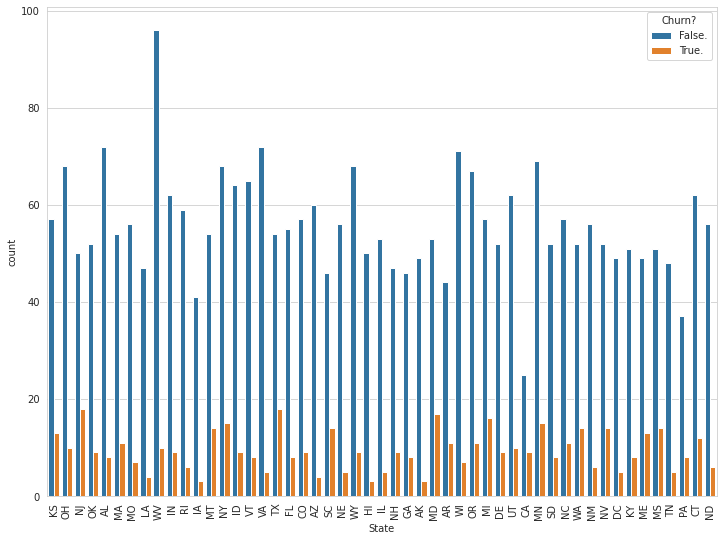

In [117]:
sns.countplot(x=data["State"], hue=data["Churn?"])
plt.xticks(rotation=90);

Not really THAT much difference between the states - which is why I won't be OneHotEncoding/Labelencoding them, but instead just dropping the column. Also, obviously, phone numbers don't matter and the columns with no/yes and true/false have to be label encoded.

In [5]:
data["Int'l Plan"] = data["Int'l Plan"].map({"yes":1, "no":0})
data["VMail Plan"] = data["VMail Plan"].map({"yes":1, "no":0})
data["Churn?"] = data["Churn?"].map({"True.":1, "False.":0})
data.drop("Phone",  inplace=True, axis=1)
data.drop("State",  inplace=True, axis=1)
data

Account Length  Area Code  Int'l Plan  VMail Plan  VMail Message  \
0                128        415           0           1             25   
1                107        415           0           1             26   
2                137        415           0           0              0   
3                 84        408           1           0              0   
4                 75        415           1           0              0   
...              ...        ...         ...         ...            ...   
3328             192        415           0           1             36   
3329              68        415           0           0              0   
3330              28        510           0           0              0   
3331             184        510           1           0              0   
3332              74        415           0           1             25   

      Day Mins  Day Calls  Day Charge  Eve Mins  Eve Calls  Eve Charge  \
0        265.1        110       45.07     197.4         99       16.78   
1        161.6        123       27.47     195.5        103       16.62   
2        243.4        114       41.38     121.2        110       10.30   
3        299.4         71       50.90      61.9         88        5.26   
4        166.7        113       28.34     148.3        122       12.61   
...        ...        ...         ...       ...        ...         ...   
3328     156.2         77       26.55     215.5        126       18.32   
3329     231.1         57       39.29     153.4         55       13.04   
3330     180.8        109       30.74     288.8         58       24.55   
3331     213.8        105       36.35     159.6         84       13.57   
3332     234.4        113       39.85     265.9         82       22.60   

      Night Mins  Night Calls  Night Charge  Intl Mins  Intl Calls  \
0          244.7           91         11.01       10.0           3   
1          254.4          103         11.45       13.7           3   
2          162.6          104          7.32       12.2           5   
3          196.9           89          8.86        6.6           7   
4          186.9          121          8.41       10.1           3   
...          ...          ...           ...        ...         ...   
3328       279.1           83         12.56        9.9           6   
3329       191.3          123          8.61        9.6           4   
3330       191.9           91          8.64       14.1           6   
3331       139.2          137          6.26        5.0          10   
3332       241.4           77         10.86       13.7           4   

      Intl Charge  CustServ Calls  Churn?  
0            2.70               1       0  
1            3.70               1       0  
2            3.29               0       0  
3            1.78               2       0  
4            2.73               3       0  
...           ...             ...     ...  
3328         2.67               2       0  
3329         2.59               3       0  
3330         3.81               2       0  
3331         1.35               2       0  
3332         3.70               0       0  

[3333 rows x 19 columns]

In [119]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Account Length  3333 non-null   int64  
 1   Area Code       3333 non-null   int64  
 2   Int'l Plan      3333 non-null   int64  
 3   VMail Plan      3333 non-null   int64  
 4   VMail Message   3333 non-null   int64  
 5   Day Mins        3333 non-null   float64
 6   Day Calls       3333 non-null   int64  
 7   Day Charge      3333 non-null   float64
 8   Eve Mins        3333 non-null   float64
 9   Eve Calls       3333 non-null   int64  
 10  Eve Charge      3333 non-null   float64
 11  Night Mins      3333 non-null   float64
 12  Night Calls     3333 non-null   int64  
 13  Night Charge    3333 non-null   float64
 14  Intl Mins       3333 non-null   float64
 15  Intl Calls      3333 non-null   int64  
 16  Intl Charge     3333 non-null   float64
 17  CustServ Calls  3333 non-null   i

In [120]:
data.isnull().sum()

Account Length    0
Area Code         0
Int'l Plan        0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn?            0
dtype: int64

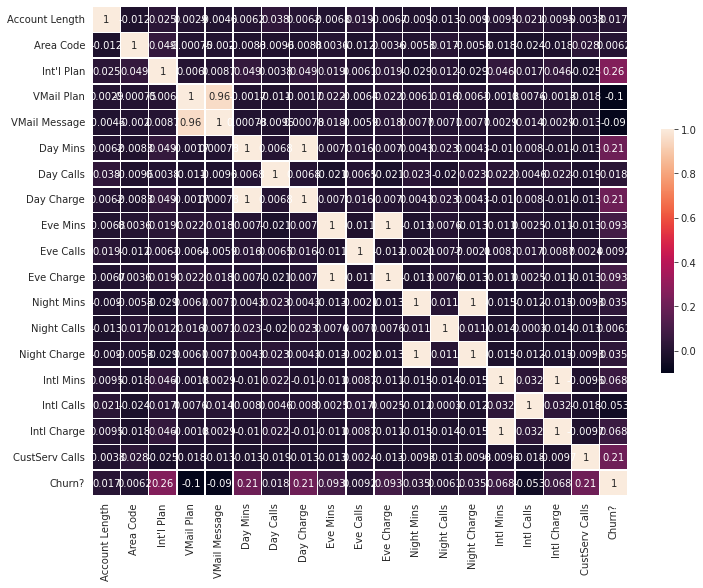

In [121]:
sns.heatmap(data.corr(), annot=True, linewidths=0.5, cbar_kws={"shrink": 0.5});

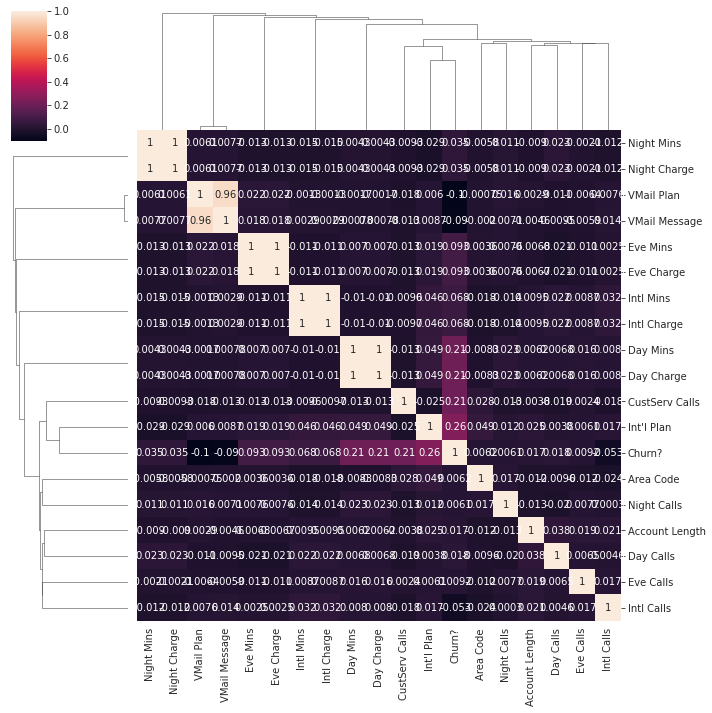

In [122]:
sns.clustermap(data.corr(), annot=True);

In [123]:
# Take a look at variables with high correlation with Churn?
abs(data.corr()["Churn?"]).sort_values()

Night Calls       0.006141
Area Code         0.006174
Eve Calls         0.009233
Account Length    0.016541
Day Calls         0.018459
Night Mins        0.035493
Night Charge      0.035496
Intl Calls        0.052844
Intl Mins         0.068239
Intl Charge       0.068259
VMail Message     0.089728
Eve Charge        0.092786
Eve Mins          0.092796
VMail Plan        0.102148
Day Charge        0.205151
Day Mins          0.205151
CustServ Calls    0.208750
Int'l Plan        0.259852
Churn?            1.000000
Name: Churn?, dtype: float64

In [124]:
unstacked_abs_corr = data.corr().abs().unstack()
unstacked_abs_corr.sort_values()[unstacked_abs_corr.sort_values() < 1][-20:]

Churn?          VMail Plan        0.102148
VMail Plan      Churn?            0.102148
Day Charge      Churn?            0.205151
Churn?          Day Charge        0.205151
Day Mins        Churn?            0.205151
Churn?          Day Mins          0.205151
CustServ Calls  Churn?            0.208750
Churn?          CustServ Calls    0.208750
                Int'l Plan        0.259852
Int'l Plan      Churn?            0.259852
VMail Plan      VMail Message     0.956927
VMail Message   VMail Plan        0.956927
Intl Charge     Intl Mins         0.999993
Intl Mins       Intl Charge       0.999993
Night Charge    Night Mins        0.999999
Night Mins      Night Charge      0.999999
Eve Charge      Eve Mins          1.000000
Eve Mins        Eve Charge        1.000000
Day Mins        Day Charge        1.000000
Day Charge      Day Mins          1.000000
dtype: float64

In [6]:
# Dropping Columns that correlate 1:1 or more than 0.95 with each other
data.drop("Day Charge",  inplace=True, axis=1)
data.drop("Eve Charge",  inplace=True, axis=1)
data.drop("Intl Charge",  inplace=True, axis=1)
data.drop("Night Charge",  inplace=True, axis=1)
data.drop("VMail Plan",  inplace=True, axis=1)

In [126]:
unstacked_abs_corr = data.corr().abs().unstack()
unstacked_abs_corr.sort_values()[unstacked_abs_corr.sort_values() < 1][-20:]

Int'l Plan      Intl Mins         0.045871
Intl Mins       Int'l Plan        0.045871
Int'l Plan      Area Code         0.048551
Area Code       Int'l Plan        0.048551
Day Mins        Int'l Plan        0.049396
Int'l Plan      Day Mins          0.049396
Churn?          Intl Calls        0.052844
Intl Calls      Churn?            0.052844
Churn?          Intl Mins         0.068239
Intl Mins       Churn?            0.068239
Churn?          VMail Message     0.089728
VMail Message   Churn?            0.089728
Eve Mins        Churn?            0.092796
Churn?          Eve Mins          0.092796
                Day Mins          0.205151
Day Mins        Churn?            0.205151
Churn?          CustServ Calls    0.208750
CustServ Calls  Churn?            0.208750
Int'l Plan      Churn?            0.259852
Churn?          Int'l Plan        0.259852
dtype: float64

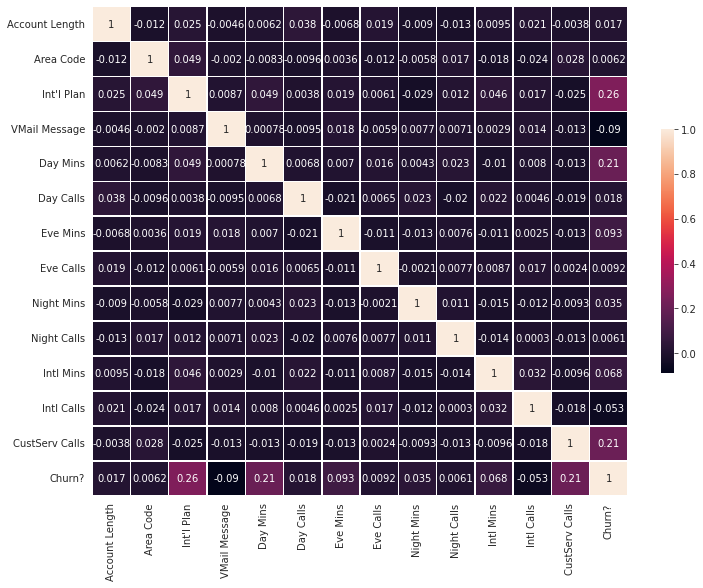

In [127]:
sns.heatmap(data.corr(), annot=True, linewidths=0.5, cbar_kws={"shrink": 0.5});

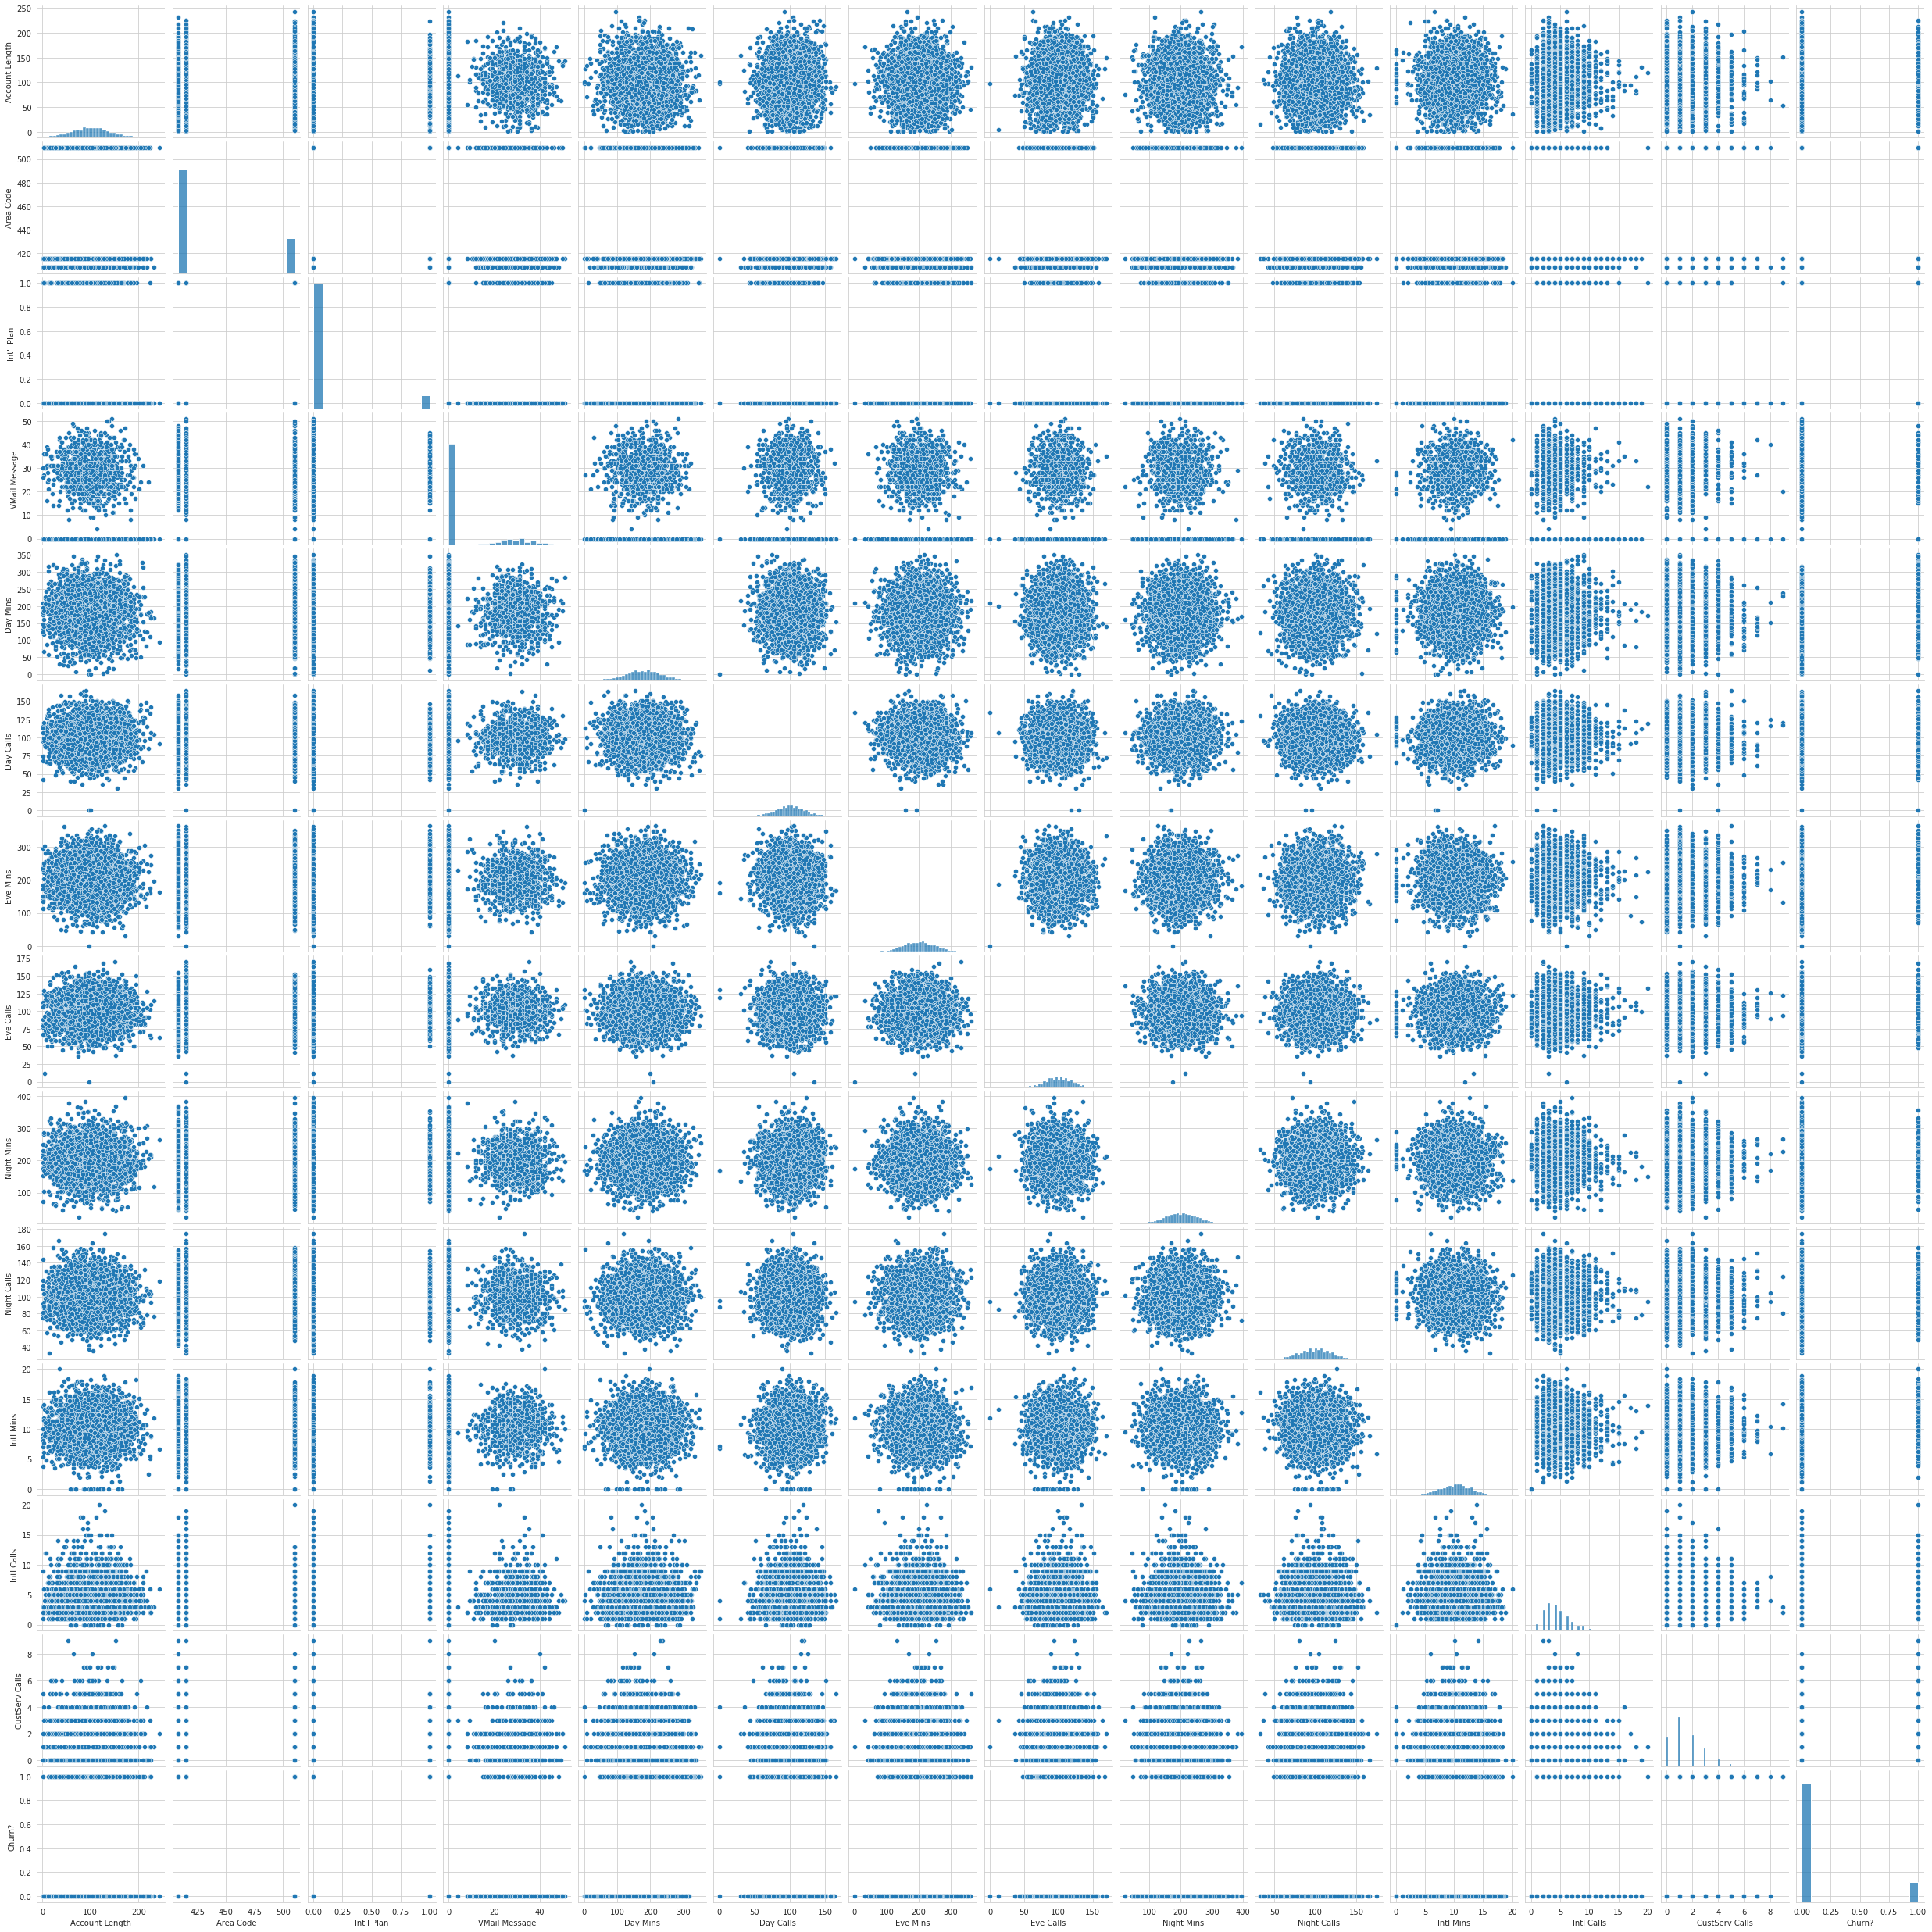

In [128]:
sns.pairplot(data);

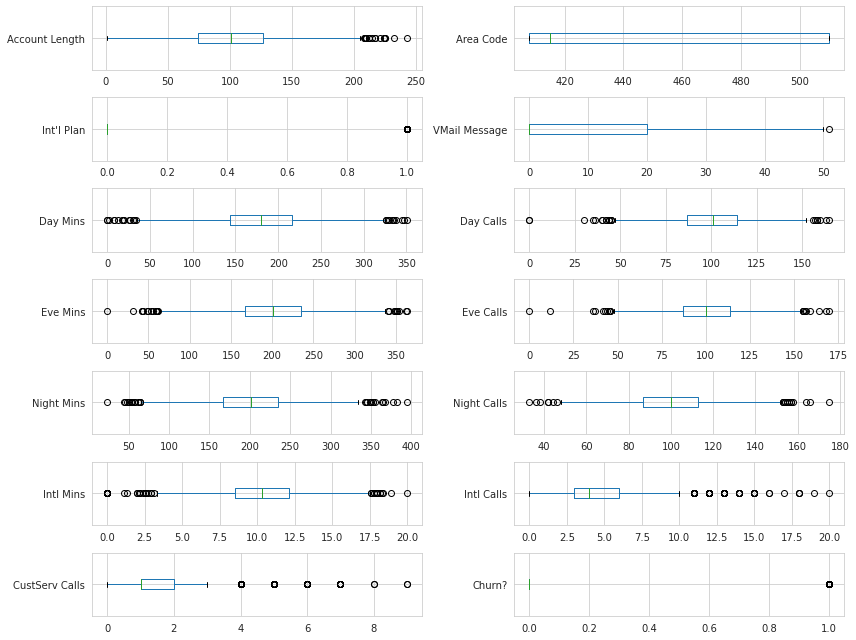

In [129]:
fig, axes = plt.subplots(7, 2)

for i, el in enumerate(list(data.columns.values)):
    data.boxplot(el, ax=axes.flatten()[i], vert=False)

plt.tight_layout()
plt.show()

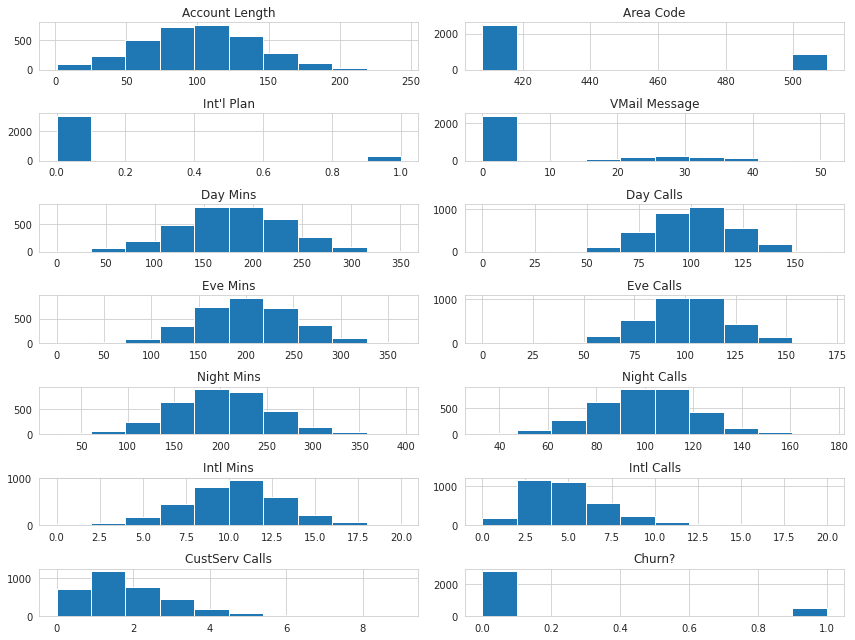

In [130]:
fig, axes = plt.subplots(7, 2)

for i, el in enumerate(list(data.columns.values)):
    data.hist(el, ax=axes.flatten()[i])

plt.tight_layout()
plt.show()

# Model training

In [52]:
X = data.drop("Churn?", axis=1)
y = data["Churn?"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

Account Length  Area Code  Int'l Plan  VMail Message  Day Mins  \
962              107        415           0              0     212.1   
1447             160        415           0              0     174.3   
2746             107        415           0              0     204.5   
72               147        510           0              0     248.6   
217              120        415           0              0     180.0   

      Day Calls  Eve Mins  Eve Calls  Night Mins  Night Calls  Intl Mins  \
962          95     150.1         88       219.8          111        7.7   
1447        105     171.3        107       220.8          131        8.3   
2746        108     162.4        110       155.0          102       13.4   
72           83     148.9         85       172.5          109        8.0   
217          80     224.2         82       265.4           91        4.7   

      Intl Calls  CustServ Calls  
962            2               3  
1447           2               0  
2746           1               3  
72             4               3  
217            7               3

CatBoostClassifier: 0.8195
accuracy_score:	0.9496
precision_score:0.9293
recall_score: 	0.8527
f1_score: 	0.8856


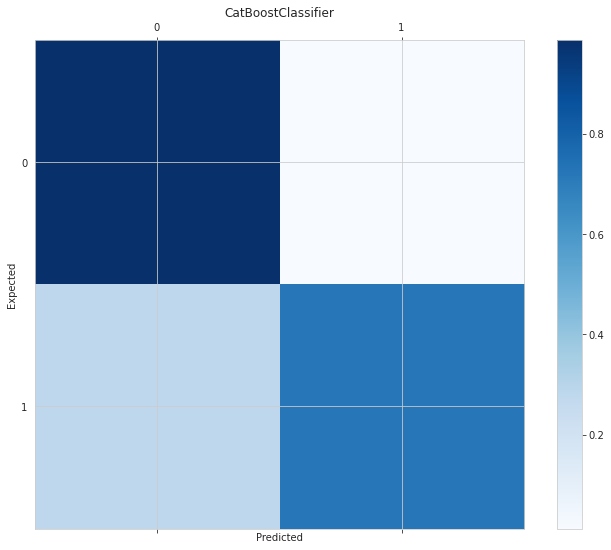

LGBMClassifier: 0.7979
accuracy_score:	0.9568
precision_score:0.9435
recall_score: 	0.8712
f1_score: 	0.9027


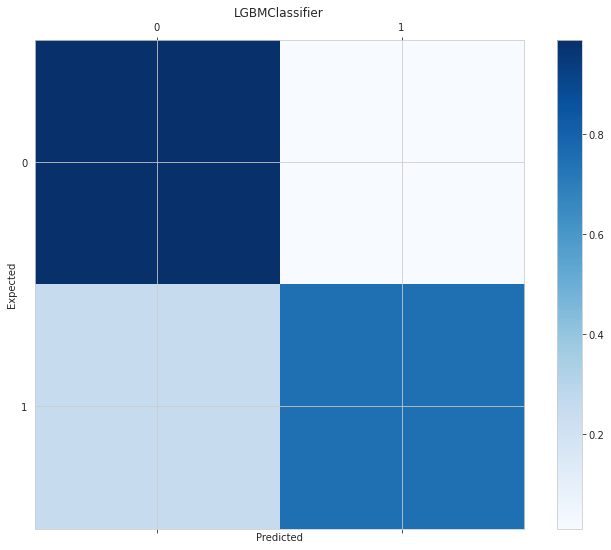

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
LGBMClassifier: 0.7255
accuracy_score:	0.9305
precision_score:0.8665
recall_score: 	0.8344
f1_score: 	0.8493


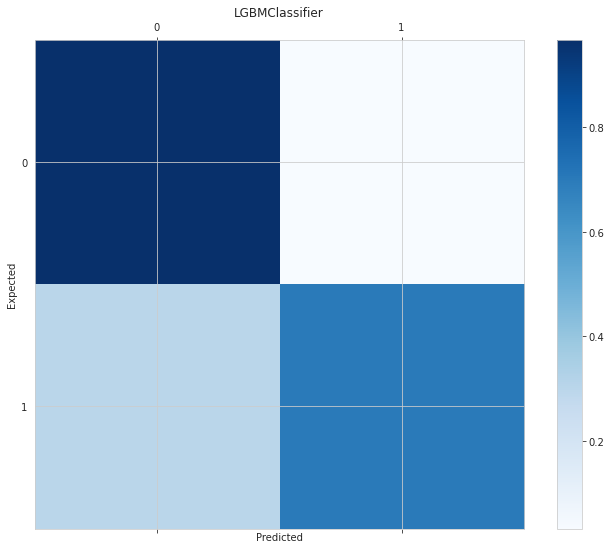

XGBClassifier: 0.807
accuracy_score:	0.9472
precision_score:0.9233
recall_score: 	0.8477
f1_score: 	0.8801


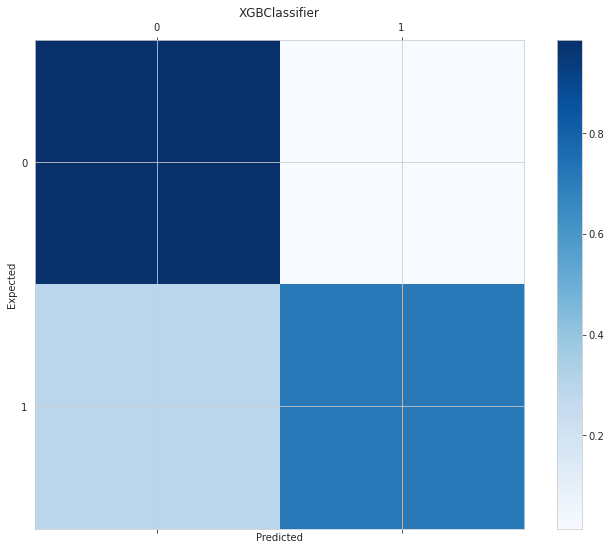

XGBRFClassifier: 0.7773
accuracy_score:	0.94
precision_score:0.912
recall_score: 	0.8257
f1_score: 	0.8615


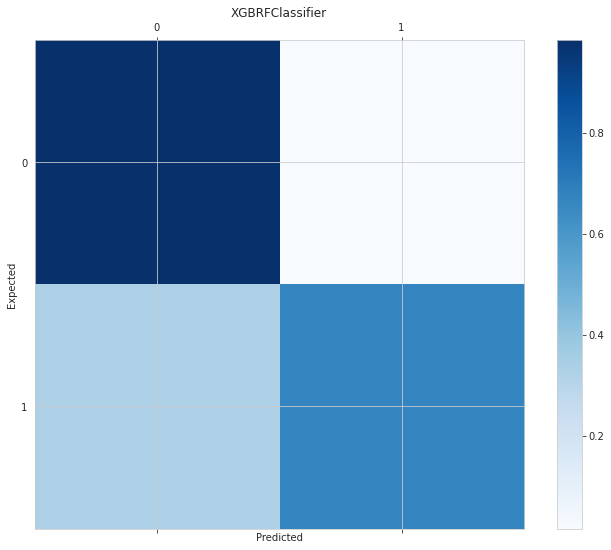

In [9]:
from sklearn.metrics import confusion_matrix


cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED, verbosity = 0)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)

models = [("CAT", cat), 
          ("LGBM", lgbm), 
          ("LGBM_RF", lgbm_rf), 
          ("XGB", xgb), 
          ("XGB_RF", xgb_rf)]

for model in models:
    model[1].fit(X_train, y_train)
    scores = cross_val_score(model[1], X_train, y_train, cv=3, scoring="f1")
    print(f"{model[1].__class__.__name__}: {round(scores.mean(), 4)}")
    
    y_pred = model[1].predict(X_test)
    print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred), 4)}')
    print(f'precision_score:{round(precision_score(y_test, y_pred, average="macro"), 4)}')
    print(f'recall_score: \t{round(recall_score(y_test, y_pred, average="macro"), 4)}')
    print(f'f1_score: \t{round(f1_score(y_test, y_pred, average="macro"), 4)}')
    

    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='true')
    # print('Confusion matrix:\n', conf_mat)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.title(model[1].__class__.__name__)
    plt.show()

CatBoostClassifier and XGBRFClassifier seem to perform quite well. Let's try out these ones.

## Hyperparameter tuning:

### CatBoosting

In [8]:
# Log loss
learning_rate = [0.0001, 0.001, 0.01, 0.1, 1]
depth = [2, 5, 8, 11, 14, 17, 20]
param_grid = {
    'learning_rate': learning_rate,
    'depth': depth,
    'l2_leaf_reg': [1, 3, 5, 7, 9]
    
}

cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
grid_search_result = cat.grid_search(param_grid, 
                                       X=X_train, 
                                       y=y_train, 
                                       plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.6278262116
bestIteration = 999

0:	loss: 0.6278262	best: 0.6278262 (0)	total: 420ms	remaining: 1m 13s

bestTest = 0.3836101859
bestIteration = 999

1:	loss: 0.3836102	best: 0.3836102 (1)	total: 764ms	remaining: 1m 6s

bestTest = 0.2069147404
bestIteration = 999

2:	loss: 0.2069147	best: 0.2069147 (2)	total: 1.13s	remaining: 1m 4s

bestTest = 0.1778021867
bestIteration = 328

3:	loss: 0.1778022	best: 0.1778022 (3)	total: 1.51s	remaining: 1m 4s

bestTest = 0.2115988625
bestIteration = 37

4:	loss: 0.2115989	best: 0.1778022 (3)	total: 1.86s	remaining: 1m 3s

bestTest = 0.6280019083
bestIteration = 999

5:	loss: 0.6280019	best: 0.1778022 (3)	total: 2.23s	remaining: 1m 2s

bestTest = 0.3834419237
bestIteration = 999

6:	loss: 0.3834419	best: 0.1778022 (3)	total: 2.63s	remaining: 1m 3s

bestTest = 0.2078231131
bestIteration = 997

7:	loss: 0.2078231	best: 0.1778022 (3)	total: 3.08s	remaining: 1m 4s

bestTest = 0.176956765
bestIteration = 424

8:	loss: 0.1769568	best: 0.1769568 


bestTest = 0.3009938223
bestIteration = 999

71:	loss: 0.3009938	best: 0.1515784 (28)	total: 2m 43s	remaining: 3m 54s

bestTest = 0.1685834558
bestIteration = 997

72:	loss: 0.1685835	best: 0.1515784 (28)	total: 2m 48s	remaining: 3m 55s

bestTest = 0.1666278068
bestIteration = 180

73:	loss: 0.1666278	best: 0.1515784 (28)	total: 2m 54s	remaining: 3m 57s

bestTest = 0.2079709965
bestIteration = 3

74:	loss: 0.2079710	best: 0.1515784 (28)	total: 2m 58s	remaining: 3m 58s

bestTest = 0.5945847808
bestIteration = 999

75:	loss: 0.5945848	best: 0.1515784 (28)	total: 3m 18s	remaining: 4m 18s

bestTest = 0.2708031675
bestIteration = 999

76:	loss: 0.2708032	best: 0.1515784 (28)	total: 3m 41s	remaining: 4m 41s

bestTest = 0.1804660216
bestIteration = 865

77:	loss: 0.1804660	best: 0.1515784 (28)	total: 4m 5s	remaining: 5m 5s

bestTest = 0.1816198153
bestIteration = 87

78:	loss: 0.1816198	best: 0.1515784 (28)	total: 4m 33s	remaining: 5m 31s

bestTest = 0.2593240781
bestIteration = 1

79:	loss:

In [15]:
print(grid_search_result['params']) # Chosen as the lowest log
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED, depth=5, l2_leaf_reg=1, learning_rate=0.1)
cat.fit(X_train, y_train)

scores = cross_val_score(cat, X_train, y_train, cv=3, scoring="f1")
print(f"{cat.__class__.__name__}: {round(scores.mean(), 4)}")

y_pred = cat.predict(X_test)
print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_pred, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_pred, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_pred, average="macro"), 4)}')

{'depth': 5, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
CatBoostClassifier: 0.8174
accuracy_score:	0.946
precision_score:0.9151
recall_score: 	0.8506
f1_score: 	0.8789


In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': learning_rate,
    'depth': depth,
    'l2_leaf_reg': [1, 3, 5, 7, 9]
    
}
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
Grid_CBC = GridSearchCV(estimator=cat, param_grid = param_grid, n_jobs=-1, scoring='f1_macro')
Grid_CBC.fit(X_train, y_train)

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7f6ebe04f790>,
             n_jobs=-1,
             param_grid={'depth': [2, 5, 8, 11, 14, 17, 20],
                         'l2_leaf_reg': [1, 3, 5, 7, 9],
                         'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1]},
             scoring='f1_macro')

In [43]:
print(Grid_CBC.best_params_)
print(Grid_CBC.best_score_)
print(Grid_CBC.best_estimator_)

{'depth': 5, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
0.9151696369232866


In [53]:
y_pred = Grid_CBC.best_estimator_.predict(X_test)

print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_pred, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_pred, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_pred, average="macro"), 4)}')

accuracy_score:	0.952
precision_score:0.9317
recall_score: 	0.8612
f1_score: 	0.8919


In [17]:
pd.DataFrame(grid_search_result['cv_results']).set_index("iterations")

test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
iterations                                                            
0                    0.600633          0.003299            0.601013   
1                    0.549619          0.002401            0.549683   
2                    0.499813          0.013366            0.497760   
3                    0.451451          0.007573            0.447347   
4                    0.414069          0.008868            0.407490   
...                       ...               ...                 ...   
995                  0.217277          0.016808            0.001842   
996                  0.217254          0.016769            0.001842   
997                  0.217304          0.016733            0.001841   
998                  0.217403          0.016661            0.001838   
999                  0.217375          0.016683            0.001837   

            train-Logloss-std  
iterations                     
0                    0.000725  
1                    0.000869  
2                    0.011659  
3                    0.004993  
4                    0.006075  
...                       ...  
995                  0.000040  
996                  0.000040  
997                  0.000039  
998                  0.000038  
999                  0.000038  

[1000 rows x 4 columns]

### XGBRFClassifier

In [54]:
param_grid_xgb = {
            'n_estimators': [400, 700, 1000],
            "learning_rate": [0.01, 0.05, 0.10, 0.15, 0.20],
            "max_depth": [  3 , 4 , 5, 6,  8, 10, 12, 15 ],
            "min_child_weight": [ 1, 3, 5, 7 ],
            "gamma": [0.0, 0.1, 0.2, 0.3, 0.4 ],
            "colsample_bytree": [  0.3, 0.4, 0.5, 0.7 ],
            "random_state": [SEED]}


xgb_rf = xgboost.XGBRFClassifier()
gs = GridSearchCV(
        estimator=xgb_rf,
        param_grid=param_grid_xgb, 
        n_jobs=-1, 
        scoring='f1_macro',
        verbose=2
    )


In [55]:
model = gs.fit(X_train, y_train)

Fitting 5 folds for each of 9600 candidates, totalling 48000 fits


KeyboardInterrupt: 

Worked whole day - never finished, so I decided to test less parameters.

In [56]:
param_grid_xgb = {
            'n_estimators': [100, 200],
            "learning_rate": [0.01, 0.10, 0.5],
            "max_depth": [3, 5, 10],
            "min_child_weight": [ 1, 3, 5],
#             "gamma": [0.0, 0.1, 0.2, 0.3, 0.4 ],
#             "colsample_bytree": [  0.3, 0.4, 0.5, 0.7 ],
            "random_state": [SEED]}


xgb_rf = xgboost.XGBRFClassifier()
gs = GridSearchCV(
        estimator=xgb_rf,
        param_grid=param_grid_xgb, 
        n_jobs=-1, 
        scoring='f1_macro',
        verbose=2
    )


In [57]:
model = gs.fit(X_train, y_trzain)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [58]:
print(gs.best_params_)
print(gs.best_score_)
print(gs.best_estimator_)

{'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 200, 'random_state': 111}
0.8957988165696118
XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, enable_categorical=False, gamma=0,
                gpu_id=-1, importance_type=None, interaction_constraints='',
                learning_rate=0.01, max_delta_step=0, max_depth=10,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=200, n_jobs=8, num_parallel_tree=200,
                objective='binary:logistic', predictor='auto', random_state=111,
                reg_alpha=0, scale_pos_weight=1, tree_method='exact',
                validate_parameters=1, verbosity=None)


In [59]:
y_pred = gs.best_estimator_.predict(X_test)

print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_pred, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_pred, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_pred, average="macro"), 4)}')

accuracy_score:	0.9412
precision_score:0.917
recall_score: 	0.8264
f1_score: 	0.8637


Catboosting is better.

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

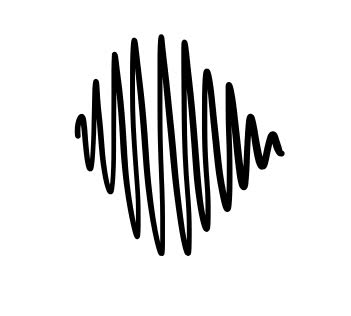

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**